In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import tensorflow as tf
import os, sys, time
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import utils, optimization, metrics, plot
import pickle

# Parameters

In [3]:
spix = 256
path = '../data/size{}_splits1000_n500x3/'.format(spix)
input_pattern = 'Box_70*snapshot_050'
file_ext = '.dat'
k = 10

# Data handling

Load the data

In [4]:
queue = []
for file in os.listdir(path):
    if file.endswith(file_ext) and (np.all([x in file for x in input_pattern.split("*")])):
        queue.append(os.path.join(path, file))
nsamples = len(queue)
print('They are {} "{}" files.'.format(nsamples, file_ext))      

They are 15000 ".dat" files.


In [5]:
# nsamples = 5000
input_img = np.vstack(map(lambda i:np.fromfile(queue[i], dtype=float32), range(nsamples)))
input_img.resize([nsamples,spix,spix])

In [6]:
input_img = utils.forward_map(input_img,k)

# input_img = np.log(input_img+0.001)

# p = np.random.permutation(nsamples)
# input_img = input_img[p,]

Let us plot 16 images

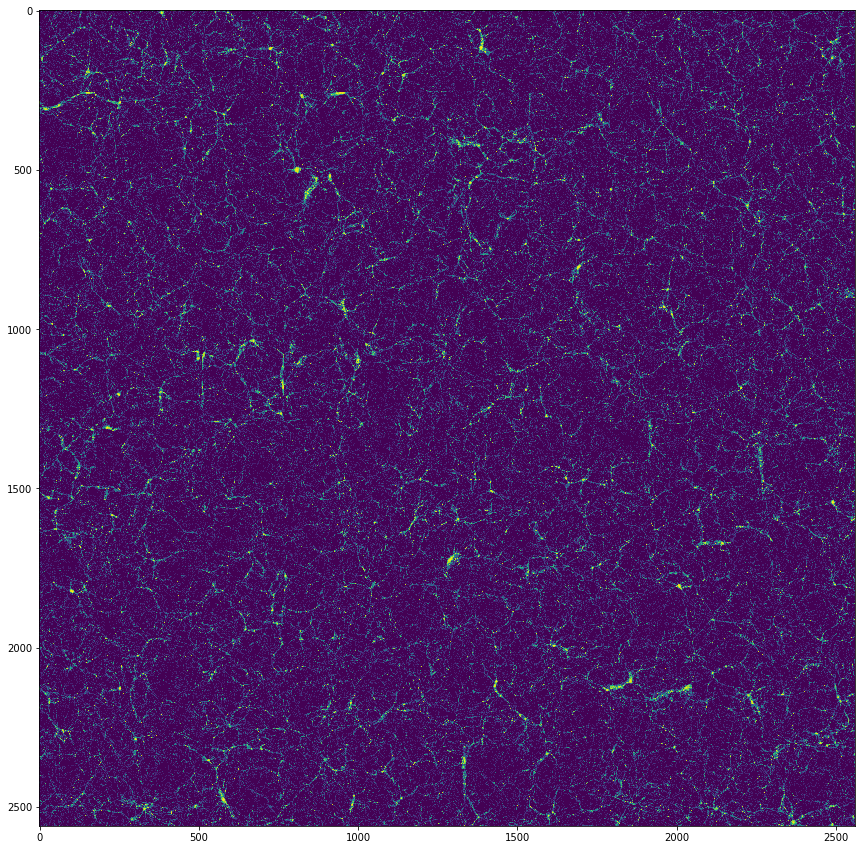

In [7]:
plt.figure(figsize=(15,15))
utils.draw_images(input_img,nx=10,ny=10,px=spix,py=spix)

Let us make small patches of 64 :-)

In [8]:
ns = 128
cut = spix//ns
img_small = np.zeros([nsamples*cut*cut, ns, ns])
for i in range(cut):
    for j in range(cut):
        k = j + i*cut 
        img_small[k*nsamples:(k+1)*nsamples,:,:] = input_img[:,i*ns:(i+1)*ns,j*ns:(j+1)*ns]


# # Reduce the size
# ns = 64
# cut = spix//ns
# img_small = input_img[:,:ns,:ns].copy()
# del input_img

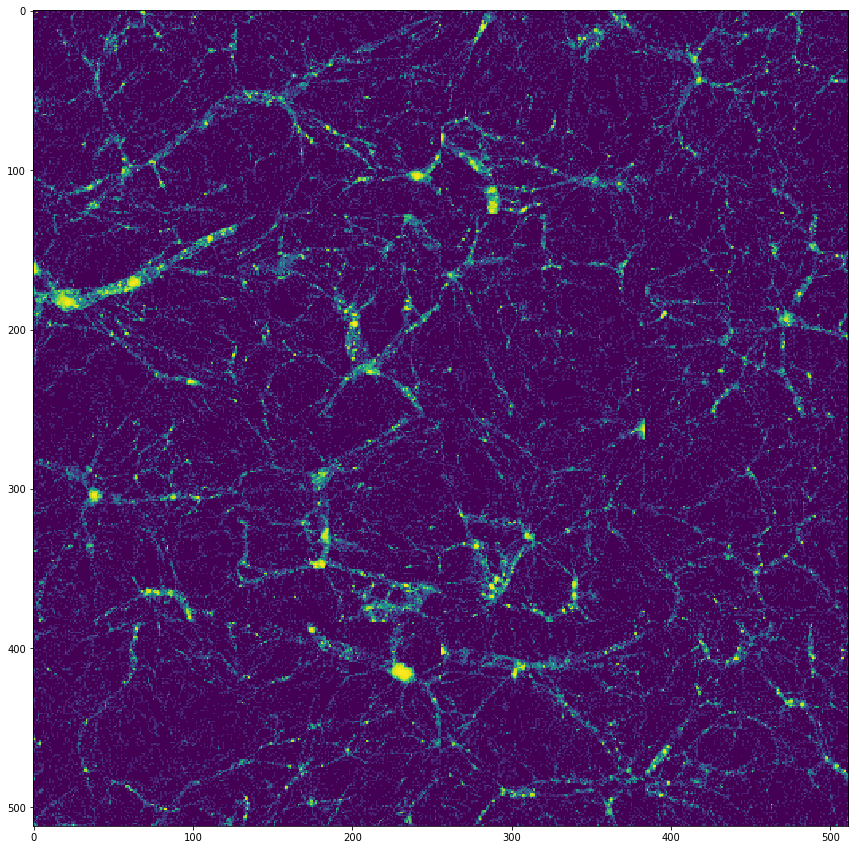

In [9]:
plt.figure(figsize=(15,15))
utils.draw_images(img_small,nx=4,ny=4,px=ns,py=ns)

# A) The WGAN

In [10]:
def current_time_str():
    import time, datetime
    d = datetime.datetime.fromtimestamp(time.time())
    return str(d.year)+ '_' + str(d.month)+ '_' + str(d.day)+ '_' + str(d.hour)+ '_' + str(d.minute)

time_str = current_time_str() 
global_path = '../../saved_result/'


## Parameters

In [11]:
params_discriminator = dict()
params_discriminator['stride'] = [2, 2, 2, 2, 1]
params_discriminator['nfilter'] = [8, 32, 64,  128, 32]
params_discriminator['shape'] = [[5, 5],[5, 5], [5, 5], [3, 3], [3, 3]]
params_discriminator['batch_norm'] = [True, True, True, True, True]
params_discriminator['full'] = [128]
params_discriminator['summary'] = True

params_generator = dict()
params_generator['stride'] = [2, 2, 2, 2, 1]
params_generator['latent_dim'] = 100
params_generator['nfilter'] = [64, 128, 64, 32, 1]
params_generator['shape'] = [[3, 3], [3, 3], [5, 5], [5, 5], [5, 5]]
params_generator['batch_norm'] = [True, True, True, True]
params_generator['full'] = [8*8*64]
params_generator['summary'] = True
params_generator['non_lin'] = 'tanh'

params_optimization = dict()
params_optimization['gamma_gp'] = 10
params_optimization['batch_size'] = 16
params_optimization['optimizer'] = 'adam' # rmsprop / adam
params_optimization['disc_learning_rate'] = 1e-5
params_optimization['gen_learning_rate'] = 1e-5
params_optimization['beta1'] = 0.99
params_optimization['beta2'] = 0.999
params_optimization['epsilon'] = 1e-8
params_optimization['epoch'] = 50

params = dict()
params['generator'] = params_generator
params['discriminator'] = params_discriminator
params['optimization'] = params_optimization

params['image_size'] = [ns, ns]
params['sum_every'] = 200
params['viz_every'] = 200
params['save_every'] = 2000
params['name'] = 'WGAN{}'.format(ns)
params['summary_dir'] = global_path + params['name'] + time_str +'summary/'
params['save_dir'] = global_path + params['name'] + time_str + 'checkpoints/'

params['clip_max_real'] = False
params['log_clip'] = 0.1
params['sigma_smooth'] = 1
params['k'] = k





## Build the model

In [ ]:
from model import WGanModel
from gan import GAN

wgan = GAN(params, WGanModel)

Generator 
------------------------------------------------------------
     The input is of size (?, 100)
     0 Full layer with 4096 outputs
         Size of the variables: (?, 4096)
     Reshape to (?, 8, 8, 64)
     1 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 16, 16, 64)
     2 Deconv layer with 128 channels
         Batch norm
         Size of the variables: (?, 32, 32, 128)
     3 Deconv layer with 64 channels
         Batch norm
         Size of the variables: (?, 64, 64, 64)
     4 Deconv layer with 32 channels
         Batch norm
         Size of the variables: (?, 128, 128, 32)
     5 Deconv layer with 1 channels
         Size of the variables: (?, 128, 128, 1)
    Non lienarity: tanh
     The output is of size (?, 128, 128, 1)
------------------------------------------------------------

Discriminator 
------------------------------------------------------------
     The input is of size (?, 128, 128, 1)
     0 Conv layer with 8 ch

## Train the model
Note that the input is the processed data... Maybe, we should change that

In [14]:
wgan.train(img_small)

Epoch: [ 0] [  99/15000] Counter:100	( 0.4 min	69.42 examples/sec	0.230 sec/batch)	L_Disc:27.17881584	L_Gen:0.20417248
Epoch: [ 0] [ 199/15000] Counter:200	( 0.7 min	86.11 examples/sec	0.186 sec/batch)	L_Disc:5.63795710	L_Gen:0.77873129
 [*] [Fake, Real] Min [6.326, 0.172],	Median [28.666,1.135],	Mean [3.796E+01,3.161E+00],	 Max [5.716E+02,1.917E+02],	 Var [1.178E+03,1.317E+02]
 [*] [Comp, Fake, Real] PeakDistance:[1.461, 0.090, 0.158]	CrossPS:[-2.131, 2.809, 12.454]	PSD_Diff:192054.644
 [*] New PSD Low achieved 192054.644001 (was 10000000000.000000)
Epoch: [ 0] [ 299/15000] Counter:300	( 1.1 min	67.87 examples/sec	0.236 sec/batch)	L_Disc:-0.25034237	L_Gen:1.36770773
Epoch: [ 0] [ 399/15000] Counter:400	( 1.4 min	84.64 examples/sec	0.189 sec/batch)	L_Disc:0.16856992	L_Gen:1.62878132
 [*] [Fake, Real] Min [6.393, 0.186],	Median [26.055,1.000],	Mean [3.289E+01,2.338E+00],	 Max [4.599E+02,1.246E+02],	 Var [7.336E+02,6.861E+01]
 [*] [Comp, Fake, Real] PeakDistance:[1.420, 0.122, 0.161]	Cro

Epoch: [ 0] [3399/15000] Counter:3400	(11.5 min	84.08 examples/sec	0.190 sec/batch)	L_Disc:-0.67784917	L_Gen:0.25697523
 [*] [Fake, Real] Min [0.120, 0.177],	Median [1.183,1.269],	Mean [4.221E+01,4.637E+00],	 Max [1.752E+04,4.910E+02],	 Var [1.077E+06,1.145E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.596, 0.741, 0.206]	CrossPS:[-42.508, 13.210, 4.127]	PSD_Diff:2708751.585
Epoch: [ 0] [3499/15000] Counter:3500	(11.9 min	73.94 examples/sec	0.216 sec/batch)	L_Disc:-0.85605341	L_Gen:1.16815948
Epoch: [ 0] [3599/15000] Counter:3600	(12.2 min	85.82 examples/sec	0.186 sec/batch)	L_Disc:-0.14820471	L_Gen:1.06526232
 [*] [Fake, Real] Min [0.121, 0.184],	Median [0.835,1.102],	Mean [4.159E+00,3.083E+00],	 Max [2.760E+02,2.790E+02],	 Var [5.048E+02,1.787E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.342, 0.288, 0.214]	CrossPS:[-9.525, -1.076, 13.562]	PSD_Diff:101996.912
Epoch: [ 0] [3699/15000] Counter:3700	(12.5 min	74.36 examples/sec	0.215 sec/batch)	L_Disc:-1.21179771	L_Gen:1.57632458
Epoch: [ 

Epoch: [ 0] [6699/15000] Counter:6700	(22.6 min	74.49 examples/sec	0.215 sec/batch)	L_Disc:-1.60489368	L_Gen:6.92988777
Epoch: [ 0] [6799/15000] Counter:6800	(22.9 min	86.08 examples/sec	0.186 sec/batch)	L_Disc:-1.79962206	L_Gen:5.09786987
 [*] [Fake, Real] Min [0.124, 0.180],	Median [1.732,1.148],	Mean [2.557E+01,2.714E+00],	 Max [9.225E+03,2.689E+02],	 Var [1.969E+05,1.710E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.638, 0.928, 0.183]	CrossPS:[-17.608, -50.196, -2.594]	PSD_Diff:3723137.434
Epoch: [ 0] [6899/15000] Counter:6900	(23.3 min	73.31 examples/sec	0.218 sec/batch)	L_Disc:-1.54047501	L_Gen:4.81296492
Epoch: [ 0] [6999/15000] Counter:7000	(23.6 min	86.33 examples/sec	0.185 sec/batch)	L_Disc:-1.46639359	L_Gen:1.94042981
 [*] [Fake, Real] Min [0.101, 0.169],	Median [1.681,1.179],	Mean [2.908E+01,3.090E+00],	 Max [2.980E+03,1.875E+02],	 Var [2.691E+04,9.512E+01]
 [*] [Comp, Fake, Real] PeakDistance:[3.901, 0.941, 0.312]	CrossPS:[-15.099, -26.034, -15.311]	PSD_Diff:738602.520
Epoc

Epoch: [ 0] [10099/15000] Counter:10100	(34.0 min	73.33 examples/sec	0.218 sec/batch)	L_Disc:-1.43442535	L_Gen:0.53462631
Epoch: [ 0] [10199/15000] Counter:10200	(34.3 min	88.75 examples/sec	0.180 sec/batch)	L_Disc:-1.59168077	L_Gen:-2.89596462
 [*] [Fake, Real] Min [0.101, 0.160],	Median [0.755,0.968],	Mean [1.609E+01,2.684E+00],	 Max [2.765E+03,3.054E+02],	 Var [1.622E+04,3.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[1.223, 0.591, 0.126]	CrossPS:[-1.744, -5.618, 0.343]	PSD_Diff:1510297.251
Epoch: [ 0] [10299/15000] Counter:10300	(34.7 min	75.97 examples/sec	0.211 sec/batch)	L_Disc:-1.01928735	L_Gen:1.75652385
Epoch: [ 0] [10399/15000] Counter:10400	(35.0 min	85.28 examples/sec	0.188 sec/batch)	L_Disc:-1.30825603	L_Gen:5.32835484
 [*] [Fake, Real] Min [0.101, 0.188],	Median [0.362,1.134],	Mean [4.119E+00,3.700E+00],	 Max [1.052E+03,4.304E+02],	 Var [2.610E+03,5.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.247, 0.262, 0.106]	CrossPS:[-15.075, -14.684, 58.794]	PSD_Diff:1090446.06

Epoch: [ 0] [13899/15000] Counter:13900	(46.7 min	73.05 examples/sec	0.219 sec/batch)	L_Disc:-0.62145722	L_Gen:-1.36729860
Epoch: [ 0] [13999/15000] Counter:14000	(47.1 min	85.11 examples/sec	0.188 sec/batch)	L_Disc:-0.81633216	L_Gen:4.09377003
 [*] [Fake, Real] Min [0.107, 0.179],	Median [0.683,1.027],	Mean [3.512E+00,3.089E+00],	 Max [3.636E+02,4.693E+02],	 Var [2.770E+02,4.141E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.236, 0.250, 0.212]	CrossPS:[-3.292, -18.294, 16.824]	PSD_Diff:19244.845
Epoch: [ 0] [14099/15000] Counter:14100	(47.4 min	71.86 examples/sec	0.223 sec/batch)	L_Disc:-0.46735916	L_Gen:5.68424034
Epoch: [ 0] [14199/15000] Counter:14200	(47.7 min	85.89 examples/sec	0.186 sec/batch)	L_Disc:-0.89282513	L_Gen:1.29773617
 [*] [Fake, Real] Min [0.105, 0.174],	Median [1.602,1.225],	Mean [3.182E+01,3.853E+00],	 Max [6.684E+03,3.223E+02],	 Var [9.164E+04,2.438E+02]
 [*] [Comp, Fake, Real] PeakDistance:[1.294, 1.034, 0.151]	CrossPS:[-10.384, -49.007, -31.270]	PSD_Diff:1063960.5

 [*] [Fake, Real] Min [0.104, 0.175],	Median [0.763,1.006],	Mean [4.892E+00,3.051E+00],	 Max [6.730E+02,4.471E+02],	 Var [9.965E+02,4.657E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.294, 0.218, 0.223]	CrossPS:[-13.516, -24.755, -38.995]	PSD_Diff:1896.553
Epoch: [ 1] [2299/15000] Counter:17300	(58.1 min	74.67 examples/sec	0.214 sec/batch)	L_Disc:-0.86802846	L_Gen:7.13257504
Epoch: [ 1] [2399/15000] Counter:17400	(58.4 min	86.68 examples/sec	0.185 sec/batch)	L_Disc:-0.77235514	L_Gen:10.18371010
 [*] [Fake, Real] Min [0.103, 0.175],	Median [0.484,0.925],	Mean [3.067E+00,1.967E+00],	 Max [5.703E+02,7.732E+01],	 Var [1.261E+03,2.069E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.282, 0.225, 0.301]	CrossPS:[10.856, -80.647, 0.387]	PSD_Diff:1333356.264
Epoch: [ 1] [2499/15000] Counter:17500	(58.8 min	75.13 examples/sec	0.213 sec/batch)	L_Disc:-0.66317171	L_Gen:8.53294754
Epoch: [ 1] [2599/15000] Counter:17600	(59.1 min	86.91 examples/sec	0.184 sec/batch)	L_Disc:-0.80131352	L_Gen:1.59151077
 [*

Epoch: [ 1] [5499/15000] Counter:20500	(68.8 min	75.89 examples/sec	0.211 sec/batch)	L_Disc:-0.77680582	L_Gen:7.56927490
Epoch: [ 1] [5599/15000] Counter:20600	(69.1 min	85.84 examples/sec	0.186 sec/batch)	L_Disc:-0.68024945	L_Gen:3.13562346
 [*] [Fake, Real] Min [0.109, 0.187],	Median [1.525,1.312],	Mean [7.837E+00,4.412E+00],	 Max [7.446E+02,4.503E+02],	 Var [2.081E+03,9.337E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.373, 0.356, 0.273]	CrossPS:[-16.290, 8.607, 11.400]	PSD_Diff:10486.960
Epoch: [ 1] [5699/15000] Counter:20700	(69.5 min	75.93 examples/sec	0.211 sec/batch)	L_Disc:-0.15507914	L_Gen:0.41492370
Epoch: [ 1] [5799/15000] Counter:20800	(69.8 min	86.66 examples/sec	0.185 sec/batch)	L_Disc:-0.80362970	L_Gen:6.91716528
 [*] [Fake, Real] Min [0.106, 0.175],	Median [0.535,1.057],	Mean [2.336E+00,2.643E+00],	 Max [3.049E+02,2.136E+02],	 Var [1.862E+02,2.026E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.351, 0.346, 0.208]	CrossPS:[1.979, 4.802, 6.479]	PSD_Diff:171013.874
Epoch: [ 1

Epoch: [ 1] [8899/15000] Counter:23900	(80.1 min	75.43 examples/sec	0.212 sec/batch)	L_Disc:-1.07943177	L_Gen:-0.49923849
Epoch: [ 1] [8999/15000] Counter:24000	(80.4 min	86.44 examples/sec	0.185 sec/batch)	L_Disc:-0.17471200	L_Gen:-2.36991382
 [*] [Fake, Real] Min [0.110, 0.191],	Median [0.942,1.298],	Mean [3.412E+00,5.085E+00],	 Max [2.237E+02,4.165E+02],	 Var [1.556E+02,6.867E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.312, 0.084, 0.221]	CrossPS:[33.838, 9.518, -7.082]	PSD_Diff:2110.182
Epoch: [ 1] [9099/15000] Counter:24100	(80.8 min	73.72 examples/sec	0.217 sec/batch)	L_Disc:-0.59014130	L_Gen:2.12734938
Epoch: [ 1] [9199/15000] Counter:24200	(81.1 min	85.39 examples/sec	0.187 sec/batch)	L_Disc:-0.64875686	L_Gen:5.67546749
 [*] [Fake, Real] Min [0.111, 0.169],	Median [0.705,1.084],	Mean [2.368E+00,3.864E+00],	 Max [1.430E+02,5.335E+02],	 Var [6.277E+01,1.312E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.448, 0.123, 0.657]	CrossPS:[13.433, 15.774, 0.031]	PSD_Diff:59455.199
Epoch: [ 

 [*] [Fake, Real] Min [0.132, 0.188],	Median [2.064,1.333],	Mean [1.021E+01,4.041E+00],	 Max [1.188E+03,4.970E+02],	 Var [2.242E+03,1.137E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.319, 0.336, 0.238]	CrossPS:[0.960, 31.988, -34.668]	PSD_Diff:5805.883
Epoch: [ 1] [12299/15000] Counter:27300	(91.5 min	75.10 examples/sec	0.213 sec/batch)	L_Disc:-0.28377044	L_Gen:-0.10648715
Epoch: [ 1] [12399/15000] Counter:27400	(91.8 min	87.17 examples/sec	0.184 sec/batch)	L_Disc:-0.23755234	L_Gen:1.72694552
 [*] [Fake, Real] Min [0.115, 0.192],	Median [0.769,1.152],	Mean [2.342E+00,4.055E+00],	 Max [1.046E+02,4.680E+02],	 Var [3.622E+01,4.965E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.177, 0.115, 0.146]	CrossPS:[-1.103, 9.472, 42.700]	PSD_Diff:186951.302
Epoch: [ 1] [12499/15000] Counter:27500	(92.1 min	75.00 examples/sec	0.213 sec/batch)	L_Disc:-0.69982761	L_Gen:6.82317591
Epoch: [ 1] [12599/15000] Counter:27600	(92.4 min	85.33 examples/sec	0.188 sec/batch)	L_Disc:-0.40184927	L_Gen:7.67650652
 [*]

Epoch: [ 2] [ 499/15000] Counter:30500	(102.2 min	74.06 examples/sec	0.216 sec/batch)	L_Disc:-0.13205867	L_Gen:1.59658253
Epoch: [ 2] [ 599/15000] Counter:30600	(102.5 min	87.43 examples/sec	0.183 sec/batch)	L_Disc:-0.71841884	L_Gen:6.53327370
 [*] [Fake, Real] Min [0.107, 0.162],	Median [0.452,1.197],	Mean [9.814E-01,3.010E+00],	 Max [2.766E+01,1.499E+02],	 Var [3.283E+00,9.309E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.138, 0.124, 0.138]	CrossPS:[0.102, 2.159, -3.077]	PSD_Diff:62017.626
Epoch: [ 2] [ 699/15000] Counter:30700	(102.8 min	73.72 examples/sec	0.217 sec/batch)	L_Disc:-0.71559703	L_Gen:8.11816311
Epoch: [ 2] [ 799/15000] Counter:30800	(103.2 min	86.24 examples/sec	0.186 sec/batch)	L_Disc:-0.36255041	L_Gen:5.60056591
 [*] [Fake, Real] Min [0.120, 0.185],	Median [1.112,1.107],	Mean [4.103E+00,2.869E+00],	 Max [2.688E+02,2.842E+02],	 Var [3.614E+02,2.003E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.282, 0.172, 0.036]	CrossPS:[4.897, 21.140, -22.951]	PSD_Diff:4869.566
Epoch: 

 [*] [Fake, Real] Min [0.116, 0.164],	Median [0.896,0.973],	Mean [2.305E+00,2.460E+00],	 Max [1.090E+02,2.870E+02],	 Var [4.392E+01,1.993E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.194, 0.165, 0.093]	CrossPS:[0.543, 7.340, -11.019]	PSD_Diff:208380.655
Epoch: [ 2] [3899/15000] Counter:33900	(113.6 min	72.35 examples/sec	0.221 sec/batch)	L_Disc:-0.48710606	L_Gen:5.02685738
Epoch: [ 2] [3999/15000] Counter:34000	(113.9 min	85.23 examples/sec	0.188 sec/batch)	L_Disc:-0.74964386	L_Gen:8.52875328
 [*] [Fake, Real] Min [0.111, 0.175],	Median [0.476,1.011],	Mean [1.112E+00,2.656E+00],	 Max [3.875E+01,2.583E+02],	 Var [6.978E+00,1.577E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.380, 0.239, 0.183]	CrossPS:[17.846, -11.328, -8.063]	PSD_Diff:64164.628
Epoch: [ 2] [4099/15000] Counter:34100	(114.2 min	73.56 examples/sec	0.218 sec/batch)	L_Disc:-0.83634686	L_Gen:7.66536140
Epoch: [ 2] [4199/15000] Counter:34200	(114.6 min	85.94 examples/sec	0.186 sec/batch)	L_Disc:-0.33043525	L_Gen:4.06579590
 [*

Epoch: [ 2] [7099/15000] Counter:37100	(124.2 min	75.28 examples/sec	0.213 sec/batch)	L_Disc:-0.27311558	L_Gen:-1.32132804
Epoch: [ 2] [7199/15000] Counter:37200	(124.6 min	87.27 examples/sec	0.183 sec/batch)	L_Disc:-0.76832443	L_Gen:3.57818604
 [*] [Fake, Real] Min [0.117, 0.181],	Median [0.568,1.026],	Mean [1.442E+00,2.882E+00],	 Max [9.981E+01,3.111E+02],	 Var [3.927E+01,3.860E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.276, 0.317, 0.209]	CrossPS:[-11.742, -8.496, -14.377]	PSD_Diff:171.738
Epoch: [ 2] [7299/15000] Counter:37300	(124.9 min	73.44 examples/sec	0.218 sec/batch)	L_Disc:-1.15090656	L_Gen:6.63836241
Epoch: [ 2] [7399/15000] Counter:37400	(125.2 min	85.23 examples/sec	0.188 sec/batch)	L_Disc:-0.09988921	L_Gen:6.94665241
 [*] [Fake, Real] Min [0.121, 0.173],	Median [1.029,0.978],	Mean [2.930E+00,2.166E+00],	 Max [1.192E+02,1.351E+02],	 Var [5.936E+01,5.297E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.328, 0.320, 0.194]	CrossPS:[-3.872, -5.114, -0.547]	PSD_Diff:8.143
 [*] Ne

 [*] [Fake, Real] Min [0.122, 0.188],	Median [0.748,1.134],	Mean [1.687E+00,3.700E+00],	 Max [6.516E+01,4.304E+02],	 Var [2.060E+01,5.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.187, 0.229, 0.106]	CrossPS:[-13.385, 1.313, 58.794]	PSD_Diff:212957.350
Epoch: [ 2] [10499/15000] Counter:40500	(135.6 min	74.83 examples/sec	0.214 sec/batch)	L_Disc:-0.83738595	L_Gen:4.09916115
Epoch: [ 2] [10599/15000] Counter:40600	(135.9 min	87.05 examples/sec	0.184 sec/batch)	L_Disc:-0.51029950	L_Gen:5.78847694
 [*] [Fake, Real] Min [0.150, 0.197],	Median [1.156,1.093],	Mean [2.257E+00,2.964E+00],	 Max [7.416E+01,2.634E+02],	 Var [1.765E+01,1.993E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.274, 0.135, 0.211]	CrossPS:[-4.562, 6.152, -6.939]	PSD_Diff:57954.360
Epoch: [ 2] [10699/15000] Counter:40700	(136.3 min	74.27 examples/sec	0.215 sec/batch)	L_Disc:-0.34495232	L_Gen:4.04681969
Epoch: [ 2] [10799/15000] Counter:40800	(136.6 min	85.40 examples/sec	0.187 sec/batch)	L_Disc:-0.31082913	L_Gen:3.07671452


Epoch: [ 2] [13699/15000] Counter:43700	(146.3 min	73.74 examples/sec	0.217 sec/batch)	L_Disc:-0.19538133	L_Gen:3.11053634
Epoch: [ 2] [13799/15000] Counter:43800	(146.6 min	85.45 examples/sec	0.187 sec/batch)	L_Disc:-0.55960017	L_Gen:4.42328024
 [*] [Fake, Real] Min [0.114, 0.180],	Median [0.597,1.165],	Mean [1.189E+00,3.956E+00],	 Max [2.548E+01,4.954E+02],	 Var [4.064E+00,7.023E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.237, 0.356, 0.076]	CrossPS:[-14.419, -9.786, -6.761]	PSD_Diff:582790.524
Epoch: [ 2] [13899/15000] Counter:43900	(147.0 min	74.85 examples/sec	0.214 sec/batch)	L_Disc:-0.99569362	L_Gen:5.55900383
Epoch: [ 2] [13999/15000] Counter:44000	(147.3 min	85.65 examples/sec	0.187 sec/batch)	L_Disc:-0.64204836	L_Gen:3.22142458
 [*] [Fake, Real] Min [0.125, 0.179],	Median [1.360,1.027],	Mean [3.856E+00,3.089E+00],	 Max [2.043E+02,4.693E+02],	 Var [1.199E+02,4.141E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.521, 0.216, 0.212]	CrossPS:[-8.509, 32.747, 16.824]	PSD_Diff:76003.70

 [*] [Fake, Real] Min [0.121, 0.190],	Median [0.612,1.247],	Mean [1.801E+00,4.616E+00],	 Max [1.438E+02,4.861E+02],	 Var [7.673E+01,7.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.236, 0.285, 0.109]	CrossPS:[1.147, -1.368, 32.990]	PSD_Diff:188960.079
Epoch: [ 3] [2099/15000] Counter:47100	(157.7 min	74.58 examples/sec	0.215 sec/batch)	L_Disc:-0.74834472	L_Gen:6.77215338
Epoch: [ 3] [2199/15000] Counter:47200	(158.0 min	86.84 examples/sec	0.184 sec/batch)	L_Disc:-0.37918416	L_Gen:6.39242935
 [*] [Fake, Real] Min [0.121, 0.175],	Median [0.766,1.006],	Mean [1.757E+00,3.051E+00],	 Max [4.952E+01,4.471E+02],	 Var [1.286E+01,4.657E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.238, 0.169, 0.223]	CrossPS:[-10.192, 6.936, -38.995]	PSD_Diff:418403.923
Epoch: [ 3] [2299/15000] Counter:47300	(158.3 min	75.22 examples/sec	0.213 sec/batch)	L_Disc:-0.58037686	L_Gen:3.64577675
Epoch: [ 3] [2399/15000] Counter:47400	(158.6 min	85.94 examples/sec	0.186 sec/batch)	L_Disc:-0.54338288	L_Gen:0.67193097
 [

Epoch: [ 3] [5299/15000] Counter:50300	(168.4 min	73.44 examples/sec	0.218 sec/batch)	L_Disc:-0.10947879	L_Gen:2.63049340
Epoch: [ 3] [5399/15000] Counter:50400	(168.7 min	86.92 examples/sec	0.184 sec/batch)	L_Disc:-1.02337492	L_Gen:6.07197475
 [*] [Fake, Real] Min [0.120, 0.160],	Median [0.716,1.183],	Mean [1.686E+00,3.168E+00],	 Max [6.949E+01,1.979E+02],	 Var [2.239E+01,9.841E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.396, 0.114, 0.187]	CrossPS:[10.730, -6.269, 17.229]	PSD_Diff:9729.485
Epoch: [ 3] [5499/15000] Counter:50500	(169.0 min	73.64 examples/sec	0.217 sec/batch)	L_Disc:-0.38823038	L_Gen:6.64357615
Epoch: [ 3] [5599/15000] Counter:50600	(169.3 min	85.38 examples/sec	0.187 sec/batch)	L_Disc:-0.48347443	L_Gen:5.07823610
 [*] [Fake, Real] Min [0.130, 0.187],	Median [1.569,1.312],	Mean [5.056E+00,4.412E+00],	 Max [3.142E+02,4.503E+02],	 Var [2.666E+02,9.337E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.241, 0.079, 0.273]	CrossPS:[3.670, -5.624, 11.400]	PSD_Diff:82409.716
Epoch:

 [*] [Fake, Real] Min [0.133, 0.156],	Median [1.288,0.966],	Mean [3.631E+00,2.026E+00],	 Max [1.897E+02,1.367E+02],	 Var [1.703E+02,4.214E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.379, 0.241, 0.284]	CrossPS:[6.060, 21.545, -4.015]	PSD_Diff:1057.017
Epoch: [ 3] [8699/15000] Counter:53700	(179.7 min	75.12 examples/sec	0.213 sec/batch)	L_Disc:-0.35512057	L_Gen:2.56621981
Epoch: [ 3] [8799/15000] Counter:53800	(180.0 min	85.69 examples/sec	0.187 sec/batch)	L_Disc:-0.86503488	L_Gen:4.78571987
 [*] [Fake, Real] Min [0.128, 0.204],	Median [0.668,1.308],	Mean [1.439E+00,3.299E+00],	 Max [5.376E+01,2.126E+02],	 Var [1.253E+01,1.217E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.398, 0.065, 0.274]	CrossPS:[-10.648, 3.014, 1.868]	PSD_Diff:9588.217
Epoch: [ 3] [8899/15000] Counter:53900	(180.4 min	74.61 examples/sec	0.214 sec/batch)	L_Disc:-0.39171124	L_Gen:6.00997877
Epoch: [ 3] [8999/15000] Counter:54000	(180.7 min	86.32 examples/sec	0.185 sec/batch)	L_Disc:-0.36306858	L_Gen:5.17385197
 [*] [Fa

Epoch: [ 3] [11899/15000] Counter:56900	(190.4 min	75.46 examples/sec	0.212 sec/batch)	L_Disc:-0.16620067	L_Gen:5.05420780
Epoch: [ 3] [11999/15000] Counter:57000	(190.7 min	86.82 examples/sec	0.184 sec/batch)	L_Disc:-0.22856250	L_Gen:5.30446720
 [*] [Fake, Real] Min [0.153, 0.184],	Median [1.391,1.191],	Mean [4.317E+00,3.385E+00],	 Max [4.733E+02,3.026E+02],	 Var [5.694E+02,2.178E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.202, 0.201, 0.155]	CrossPS:[-12.354, -1.879, -15.417]	PSD_Diff:8950.327
Epoch: [ 3] [12099/15000] Counter:57100	(191.1 min	73.78 examples/sec	0.217 sec/batch)	L_Disc:-0.31960535	L_Gen:4.00258780
Epoch: [ 3] [12199/15000] Counter:57200	(191.4 min	85.35 examples/sec	0.187 sec/batch)	L_Disc:-0.41864374	L_Gen:3.95207500
 [*] [Fake, Real] Min [0.116, 0.188],	Median [0.935,1.333],	Mean [2.035E+00,4.041E+00],	 Max [6.695E+01,4.970E+02],	 Var [1.882E+01,1.137E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.281, 0.177, 0.238]	CrossPS:[8.335, 2.382, -34.668]	PSD_Diff:188834.653

 [*] [Fake, Real] Min [0.126, 0.172],	Median [0.915,1.135],	Mean [1.980E+00,3.161E+00],	 Max [4.744E+01,1.917E+02],	 Var [1.144E+01,1.317E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.284, 0.386, 0.158]	CrossPS:[-4.460, 6.822, 12.454]	PSD_Diff:104959.577
Epoch: [ 4] [ 299/15000] Counter:60300	(201.8 min	74.43 examples/sec	0.215 sec/batch)	L_Disc:-0.37350205	L_Gen:5.75875330
Epoch: [ 4] [ 399/15000] Counter:60400	(202.1 min	85.24 examples/sec	0.188 sec/batch)	L_Disc:-0.12080993	L_Gen:6.07933950
 [*] [Fake, Real] Min [0.143, 0.186],	Median [0.959,1.000],	Mean [2.251E+00,2.338E+00],	 Max [1.055E+02,1.246E+02],	 Var [5.879E+01,6.861E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.136, 0.084, 0.161]	CrossPS:[-5.275, -7.253, -7.699]	PSD_Diff:7305.935
Epoch: [ 4] [ 499/15000] Counter:60500	(202.4 min	74.65 examples/sec	0.214 sec/batch)	L_Disc:-0.45467854	L_Gen:4.67119026
Epoch: [ 4] [ 599/15000] Counter:60600	(202.8 min	86.61 examples/sec	0.185 sec/batch)	L_Disc:-0.31422460	L_Gen:2.20786572
 [*] 

Epoch: [ 4] [3499/15000] Counter:63500	(212.4 min	74.32 examples/sec	0.215 sec/batch)	L_Disc:-0.42759052	L_Gen:4.08626461
Epoch: [ 4] [3599/15000] Counter:63600	(212.7 min	84.98 examples/sec	0.188 sec/batch)	L_Disc:-0.24938260	L_Gen:3.75317478
 [*] [Fake, Real] Min [0.151, 0.184],	Median [1.216,1.102],	Mean [2.343E+00,3.083E+00],	 Max [8.331E+01,2.790E+02],	 Var [2.212E+01,1.787E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.184, 0.153, 0.214]	CrossPS:[6.389, -0.730, 13.562]	PSD_Diff:137305.908
Epoch: [ 4] [3699/15000] Counter:63700	(213.1 min	74.50 examples/sec	0.215 sec/batch)	L_Disc:-0.29148725	L_Gen:4.59940577
Epoch: [ 4] [3799/15000] Counter:63800	(213.4 min	86.51 examples/sec	0.185 sec/batch)	L_Disc:-0.35200733	L_Gen:5.60522270
 [*] [Fake, Real] Min [0.171, 0.164],	Median [1.194,0.973],	Mean [2.380E+00,2.460E+00],	 Max [1.354E+02,2.870E+02],	 Var [3.845E+01,1.993E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.164, 0.148, 0.093]	CrossPS:[-5.962, -6.742, -11.019]	PSD_Diff:357183.890
Ep

 [*] [Fake, Real] Min [0.133, 0.180],	Median [0.980,1.148],	Mean [2.232E+00,2.714E+00],	 Max [1.064E+02,2.689E+02],	 Var [3.796E+01,1.710E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.193, 0.186, 0.183]	CrossPS:[-3.250, -1.275, -2.594]	PSD_Diff:724.377
Epoch: [ 4] [6899/15000] Counter:66900	(223.8 min	74.89 examples/sec	0.214 sec/batch)	L_Disc:-0.48567069	L_Gen:5.93345261
Epoch: [ 4] [6999/15000] Counter:67000	(224.1 min	85.33 examples/sec	0.188 sec/batch)	L_Disc:-0.31703380	L_Gen:4.29948473
 [*] [Fake, Real] Min [0.151, 0.169],	Median [1.393,1.179],	Mean [3.296E+00,3.090E+00],	 Max [1.545E+02,1.875E+02],	 Var [7.280E+01,9.512E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.317, 0.255, 0.312]	CrossPS:[-4.966, 4.657, -15.311]	PSD_Diff:2775.743
Epoch: [ 4] [7099/15000] Counter:67100	(224.4 min	76.15 examples/sec	0.210 sec/batch)	L_Disc:-0.40186176	L_Gen:3.73481655
Epoch: [ 4] [7199/15000] Counter:67200	(224.7 min	84.82 examples/sec	0.189 sec/batch)	L_Disc:-0.45887080	L_Gen:5.74035168
 [*] [F

Epoch: [ 4] [10099/15000] Counter:70100	(234.4 min	73.62 examples/sec	0.217 sec/batch)	L_Disc:-1.04892671	L_Gen:6.60564280
Epoch: [ 4] [10199/15000] Counter:70200	(234.7 min	85.28 examples/sec	0.188 sec/batch)	L_Disc:-0.26404950	L_Gen:6.91748524
 [*] [Fake, Real] Min [0.135, 0.160],	Median [0.990,0.968],	Mean [2.611E+00,2.684E+00],	 Max [9.949E+01,3.054E+02],	 Var [4.924E+01,3.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.192, 0.255, 0.126]	CrossPS:[-7.623, -11.834, 0.343]	PSD_Diff:33842.461
Epoch: [ 4] [10299/15000] Counter:70300	(235.1 min	75.22 examples/sec	0.213 sec/batch)	L_Disc:-0.44751486	L_Gen:4.42422247
Epoch: [ 4] [10399/15000] Counter:70400	(235.4 min	86.59 examples/sec	0.185 sec/batch)	L_Disc:-0.08849832	L_Gen:3.81254649
 [*] [Fake, Real] Min [0.150, 0.188],	Median [1.054,1.134],	Mean [2.236E+00,3.700E+00],	 Max [1.268E+02,4.304E+02],	 Var [1.025E+02,5.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.156, 0.166, 0.106]	CrossPS:[-11.012, 6.769, 58.794]	PSD_Diff:222997.482

 [*] [Fake, Real] Min [0.142, 0.166],	Median [1.251,1.049],	Mean [2.621E+00,2.291E+00],	 Max [1.057E+02,1.570E+02],	 Var [4.183E+01,6.883E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.275, 0.092, 0.447]	CrossPS:[15.966, -11.644, 0.084]	PSD_Diff:7568.896
Epoch: [ 4] [13499/15000] Counter:73500	(245.8 min	73.71 examples/sec	0.217 sec/batch)	L_Disc:-0.27776441	L_Gen:5.51172638
Epoch: [ 4] [13599/15000] Counter:73600	(246.1 min	86.04 examples/sec	0.186 sec/batch)	L_Disc:-0.37699127	L_Gen:6.77355576
 [*] [Fake, Real] Min [0.130, 0.171],	Median [0.858,1.116],	Mean [1.776E+00,2.572E+00],	 Max [7.911E+01,1.978E+02],	 Var [2.166E+01,6.462E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.195, 0.206, 0.135]	CrossPS:[-8.044, 2.562, -2.381]	PSD_Diff:2015.172
Epoch: [ 4] [13699/15000] Counter:73700	(246.4 min	76.18 examples/sec	0.210 sec/batch)	L_Disc:-0.38423172	L_Gen:6.15295982
Epoch: [ 4] [13799/15000] Counter:73800	(246.7 min	85.70 examples/sec	0.187 sec/batch)	L_Disc:-0.28211093	L_Gen:3.86785388
 [*

Epoch: [ 5] [1699/15000] Counter:76700	(256.4 min	73.81 examples/sec	0.217 sec/batch)	L_Disc:-0.25816682	L_Gen:6.31167841
Epoch: [ 5] [1799/15000] Counter:76800	(256.8 min	86.30 examples/sec	0.185 sec/batch)	L_Disc:-0.45798615	L_Gen:5.20773125
 [*] [Fake, Real] Min [0.157, 0.174],	Median [1.428,1.094],	Mean [4.276E+00,2.902E+00],	 Max [2.983E+02,1.768E+02],	 Var [7.297E+02,1.071E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.201, 0.111, 0.281]	CrossPS:[-5.939, -16.849, 31.694]	PSD_Diff:4667.490
Epoch: [ 5] [1899/15000] Counter:76900	(257.1 min	75.54 examples/sec	0.212 sec/batch)	L_Disc:-0.33435237	L_Gen:5.25376558
Epoch: [ 5] [1999/15000] Counter:77000	(257.4 min	86.30 examples/sec	0.185 sec/batch)	L_Disc:-0.85955995	L_Gen:6.95898247
 [*] [Fake, Real] Min [0.139, 0.190],	Median [0.772,1.247],	Mean [2.108E+00,4.616E+00],	 Max [2.768E+02,4.861E+02],	 Var [2.424E+02,7.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.303, 0.088, 0.109]	CrossPS:[-14.691, -9.065, 32.990]	PSD_Diff:5382.253
Epoc

 [*] [Fake, Real] Min [0.118, 0.165],	Median [0.835,1.001],	Mean [1.775E+00,2.787E+00],	 Max [4.874E+01,2.229E+02],	 Var [1.123E+01,1.912E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.190, 0.110, 0.258]	CrossPS:[2.203, -6.205, 18.924]	PSD_Diff:50996.609
Epoch: [ 5] [5099/15000] Counter:80100	(267.8 min	73.55 examples/sec	0.218 sec/batch)	L_Disc:-0.46410581	L_Gen:5.59399796
Epoch: [ 5] [5199/15000] Counter:80200	(268.1 min	87.47 examples/sec	0.183 sec/batch)	L_Disc:-0.42157954	L_Gen:4.63393021
 [*] [Fake, Real] Min [0.130, 0.195],	Median [1.166,1.148],	Mean [2.810E+00,2.372E+00],	 Max [1.190E+02,1.631E+02],	 Var [5.186E+01,4.988E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.202, 0.260, 0.144]	CrossPS:[1.762, -12.940, -3.935]	PSD_Diff:696.483
Epoch: [ 5] [5299/15000] Counter:80300	(268.4 min	75.59 examples/sec	0.212 sec/batch)	L_Disc:-0.18630730	L_Gen:4.35734510
Epoch: [ 5] [5399/15000] Counter:80400	(268.7 min	85.86 examples/sec	0.186 sec/batch)	L_Disc:-0.64589220	L_Gen:5.66737890
 [*] [F

Epoch: [ 5] [8299/15000] Counter:83300	(278.4 min	74.37 examples/sec	0.215 sec/batch)	L_Disc:-0.34354535	L_Gen:7.20346737
Epoch: [ 5] [8399/15000] Counter:83400	(278.7 min	85.54 examples/sec	0.187 sec/batch)	L_Disc:-0.40888709	L_Gen:6.26565266
 [*] [Fake, Real] Min [0.158, 0.168],	Median [1.264,1.035],	Mean [2.923E+00,3.169E+00],	 Max [1.001E+02,2.468E+02],	 Var [4.135E+01,1.704E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.276, 0.200, 0.203]	CrossPS:[12.831, 22.371, -0.230]	PSD_Diff:45240.335
Epoch: [ 5] [8499/15000] Counter:83500	(279.1 min	76.28 examples/sec	0.210 sec/batch)	L_Disc:-0.22489288	L_Gen:6.85552359
Epoch: [ 5] [8599/15000] Counter:83600	(279.4 min	85.91 examples/sec	0.186 sec/batch)	L_Disc:-0.31515893	L_Gen:7.83353424
 [*] [Fake, Real] Min [0.146, 0.156],	Median [1.010,0.966],	Mean [2.342E+00,2.026E+00],	 Max [7.144E+01,1.367E+02],	 Var [2.525E+01,4.214E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.212, 0.138, 0.284]	CrossPS:[-11.507, 14.572, -4.015]	PSD_Diff:8276.852
Epoc

 [*] [Fake, Real] Min [0.141, 0.189],	Median [1.234,1.325],	Mean [4.809E+00,3.884E+00],	 Max [2.816E+02,2.608E+02],	 Var [5.737E+02,2.054E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.278, 0.256, 0.264]	CrossPS:[7.985, -12.677, -2.264]	PSD_Diff:20959.095
Epoch: [ 5] [11699/15000] Counter:86700	(289.7 min	73.99 examples/sec	0.216 sec/batch)	L_Disc:-0.40945715	L_Gen:4.54115629
Epoch: [ 5] [11799/15000] Counter:86800	(290.1 min	86.02 examples/sec	0.186 sec/batch)	L_Disc:-0.17957155	L_Gen:4.91384983
 [*] [Fake, Real] Min [0.132, 0.178],	Median [0.903,0.971],	Mean [1.700E+00,1.821E+00],	 Max [6.138E+01,7.402E+01],	 Var [1.346E+01,1.469E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.269, 0.411, 0.099]	CrossPS:[0.141, 7.490, 1.369]	PSD_Diff:1.845
Epoch: [ 5] [11899/15000] Counter:86900	(290.4 min	75.93 examples/sec	0.211 sec/batch)	L_Disc:-0.05167990	L_Gen:5.74666071
Epoch: [ 5] [11999/15000] Counter:87000	(290.7 min	87.15 examples/sec	0.184 sec/batch)	L_Disc:-0.31099489	L_Gen:5.65897131
 [*] [F

Epoch: [ 5] [14899/15000] Counter:89900	(300.4 min	74.53 examples/sec	0.215 sec/batch)	L_Disc:-0.59895712	L_Gen:5.33357000
Epoch: [ 5] [14999/15000] Counter:90000	(300.7 min	84.98 examples/sec	0.188 sec/batch)	L_Disc:0.00675678	L_Gen:4.46405315
 [*] [Fake, Real] Min [0.153, 0.161],	Median [1.142,1.228],	Mean [2.854E+00,3.958E+00],	 Max [1.687E+02,5.435E+02],	 Var [1.480E+02,1.422E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.479, 0.246, 0.438]	CrossPS:[7.687, 2.358, 8.276]	PSD_Diff:101816.392
Epoch: [ 6] [  99/15000] Counter:90100	(301.1 min	72.30 examples/sec	0.221 sec/batch)	L_Disc:-0.28911403	L_Gen:5.08394718
Epoch: [ 6] [ 199/15000] Counter:90200	(301.4 min	86.68 examples/sec	0.185 sec/batch)	L_Disc:-0.51244533	L_Gen:6.04484653
 [*] [Fake, Real] Min [0.131, 0.172],	Median [0.846,1.135],	Mean [1.820E+00,3.161E+00],	 Max [8.215E+01,1.917E+02],	 Var [2.920E+01,1.317E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.173, 0.162, 0.158]	CrossPS:[-0.041, -3.450, 12.454]	PSD_Diff:56453.382
Epoch

 [*] [Fake, Real] Min [0.172, 0.194],	Median [1.358,1.031],	Mean [2.764E+00,2.658E+00],	 Max [6.628E+01,1.706E+02],	 Var [2.209E+01,8.434E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.250, 0.103, 0.277]	CrossPS:[-5.127, 4.232, 7.162]	PSD_Diff:37870.941
Epoch: [ 6] [3299/15000] Counter:93300	(311.7 min	74.54 examples/sec	0.215 sec/batch)	L_Disc:-0.07685414	L_Gen:5.53553867
Epoch: [ 6] [3399/15000] Counter:93400	(312.0 min	85.94 examples/sec	0.186 sec/batch)	L_Disc:-0.65680909	L_Gen:6.19126511
 [*] [Fake, Real] Min [0.128, 0.177],	Median [0.863,1.269],	Mean [2.215E+00,4.637E+00],	 Max [7.545E+01,4.910E+02],	 Var [4.552E+01,1.145E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.344, 0.350, 0.206]	CrossPS:[-17.449, -15.958, 4.127]	PSD_Diff:297801.435
Epoch: [ 6] [3499/15000] Counter:93500	(312.4 min	76.42 examples/sec	0.209 sec/batch)	L_Disc:-0.33236223	L_Gen:6.57081604
Epoch: [ 6] [3599/15000] Counter:93600	(312.7 min	86.85 examples/sec	0.184 sec/batch)	L_Disc:-0.27088329	L_Gen:5.26693583
 [*]

Epoch: [ 6] [6499/15000] Counter:96500	(322.4 min	74.33 examples/sec	0.215 sec/batch)	L_Disc:-0.26667261	L_Gen:5.03144836
Epoch: [ 6] [6599/15000] Counter:96600	(322.7 min	86.33 examples/sec	0.185 sec/batch)	L_Disc:-0.42804703	L_Gen:5.02093458
 [*] [Fake, Real] Min [0.152, 0.173],	Median [1.139,1.030],	Mean [1.965E+00,2.771E+00],	 Max [3.916E+01,2.510E+02],	 Var [7.940E+00,1.642E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.207, 0.097, 0.184]	CrossPS:[-3.051, 1.796, -16.257]	PSD_Diff:185603.462
Epoch: [ 6] [6699/15000] Counter:96700	(323.0 min	74.96 examples/sec	0.213 sec/batch)	L_Disc:-0.24802744	L_Gen:5.94502878
Epoch: [ 6] [6799/15000] Counter:96800	(323.4 min	86.01 examples/sec	0.186 sec/batch)	L_Disc:-0.28126875	L_Gen:6.05757904
 [*] [Fake, Real] Min [0.149, 0.180],	Median [1.127,1.148],	Mean [2.502E+00,2.714E+00],	 Max [9.801E+01,2.689E+02],	 Var [2.852E+01,1.710E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.156, 0.127, 0.183]	CrossPS:[12.113, -7.798, -2.594]	PSD_Diff:14468.161
Epo

 [*] [Fake, Real] Min [0.144, 0.194],	Median [1.084,1.246],	Mean [2.301E+00,2.717E+00],	 Max [7.119E+01,1.614E+02],	 Var [2.361E+01,5.541E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.131, 0.163, 0.088]	CrossPS:[-0.253, 9.975, -4.102]	PSD_Diff:2671.684
Epoch: [ 6] [9899/15000] Counter:99900	(333.7 min	75.33 examples/sec	0.212 sec/batch)	L_Disc:-0.25089791	L_Gen:2.64822221
Epoch: [ 6] [9999/15000] Counter:100000	(334.0 min	86.18 examples/sec	0.186 sec/batch)	L_Disc:-0.18262821	L_Gen:3.70888305
 [*] [Fake, Real] Min [0.159, 0.179],	Median [1.015,0.986],	Mean [1.671E+00,2.454E+00],	 Max [4.784E+01,2.204E+02],	 Var [7.819E+00,8.544E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.446, 0.208, 0.049]	CrossPS:[0.162, -2.850, -12.135]	PSD_Diff:112144.689
Epoch: [ 6] [10099/15000] Counter:100100	(334.4 min	74.04 examples/sec	0.216 sec/batch)	L_Disc:-0.78718555	L_Gen:4.43943405
Epoch: [ 6] [10199/15000] Counter:100200	(334.7 min	85.54 examples/sec	0.187 sec/batch)	L_Disc:-0.32613310	L_Gen:4.67358208


Epoch: [ 6] [13099/15000] Counter:103100	(344.4 min	74.30 examples/sec	0.215 sec/batch)	L_Disc:-0.58341616	L_Gen:3.36456037
Epoch: [ 6] [13199/15000] Counter:103200	(344.7 min	84.70 examples/sec	0.189 sec/batch)	L_Disc:-0.33698437	L_Gen:2.49790812
 [*] [Fake, Real] Min [0.148, 0.184],	Median [1.018,1.083],	Mean [2.111E+00,2.431E+00],	 Max [8.610E+01,1.479E+02],	 Var [2.036E+01,5.648E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.278, 0.291, 0.229]	CrossPS:[-7.318, 7.674, 3.497]	PSD_Diff:17533.534
Epoch: [ 6] [13299/15000] Counter:103300	(345.0 min	76.00 examples/sec	0.211 sec/batch)	L_Disc:-0.37249252	L_Gen:2.50623274
Epoch: [ 6] [13399/15000] Counter:103400	(345.4 min	86.45 examples/sec	0.185 sec/batch)	L_Disc:-0.03240304	L_Gen:3.93986869
 [*] [Fake, Real] Min [0.138, 0.166],	Median [0.981,1.049],	Mean [1.967E+00,2.291E+00],	 Max [6.206E+01,1.570E+02],	 Var [1.825E+01,6.883E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.321, 0.193, 0.447]	CrossPS:[-1.119, -4.332, 0.084]	PSD_Diff:7852.971


 [*] [Fake, Real] Min [0.127, 0.188],	Median [0.901,1.055],	Mean [2.880E+00,2.289E+00],	 Max [1.665E+02,1.731E+02],	 Var [1.729E+02,5.670E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.196, 0.212, 0.170]	CrossPS:[-9.204, 10.202, -7.834]	PSD_Diff:14784.909
Epoch: [ 7] [1499/15000] Counter:106500	(355.7 min	74.59 examples/sec	0.214 sec/batch)	L_Disc:-0.26867747	L_Gen:3.76463723
Epoch: [ 7] [1599/15000] Counter:106600	(356.0 min	87.10 examples/sec	0.184 sec/batch)	L_Disc:-0.41689876	L_Gen:3.45679903
 [*] [Fake, Real] Min [0.184, 0.182],	Median [1.379,1.192],	Mean [2.716E+00,2.883E+00],	 Max [1.591E+02,1.940E+02],	 Var [9.091E+01,1.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.662, 0.149, 0.203]	CrossPS:[2.321, 5.444, 1.053]	PSD_Diff:19732.184
Epoch: [ 7] [1699/15000] Counter:106700	(356.4 min	75.54 examples/sec	0.212 sec/batch)	L_Disc:-0.08055422	L_Gen:3.24613476
Epoch: [ 7] [1799/15000] Counter:106800	(356.7 min	87.69 examples/sec	0.182 sec/batch)	L_Disc:-0.32866004	L_Gen:3.84358692
 [*

Epoch: [ 7] [4699/15000] Counter:109700	(366.4 min	74.07 examples/sec	0.216 sec/batch)	L_Disc:-0.30378801	L_Gen:3.61866260
Epoch: [ 7] [4799/15000] Counter:109800	(366.7 min	86.91 examples/sec	0.184 sec/batch)	L_Disc:-0.29789513	L_Gen:3.36324358
 [*] [Fake, Real] Min [0.135, 0.181],	Median [0.936,1.029],	Mean [2.228E+00,2.143E+00],	 Max [1.013E+02,1.512E+02],	 Var [3.475E+01,5.663E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.210, 0.149, 0.103]	CrossPS:[2.819, -8.525, -6.117]	PSD_Diff:2818.391
Epoch: [ 7] [4899/15000] Counter:109900	(367.0 min	74.16 examples/sec	0.216 sec/batch)	L_Disc:-0.42945737	L_Gen:3.16263342
Epoch: [ 7] [4999/15000] Counter:110000	(367.3 min	85.69 examples/sec	0.187 sec/batch)	L_Disc:-0.26489493	L_Gen:2.95085144
 [*] [Fake, Real] Min [0.149, 0.165],	Median [1.093,1.001],	Mean [2.595E+00,2.787E+00],	 Max [1.808E+02,2.229E+02],	 Var [1.012E+02,1.912E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.187, 0.110, 0.258]	CrossPS:[-18.682, -6.334, 18.924]	PSD_Diff:1128.206
Ep

 [*] [Fake, Real] Min [0.152, 0.178],	Median [1.006,1.188],	Mean [2.524E+00,3.325E+00],	 Max [1.275E+02,2.309E+02],	 Var [5.579E+01,1.858E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.393, 0.227, 0.386]	CrossPS:[11.048, 5.847, -7.424]	PSD_Diff:96588.654
Epoch: [ 7] [8099/15000] Counter:113100	(377.7 min	75.36 examples/sec	0.212 sec/batch)	L_Disc:-0.21046801	L_Gen:2.75164628
Epoch: [ 7] [8199/15000] Counter:113200	(378.0 min	87.54 examples/sec	0.183 sec/batch)	L_Disc:-0.32736287	L_Gen:3.09650135
 [*] [Fake, Real] Min [0.177, 0.181],	Median [1.401,1.181],	Mean [3.046E+00,3.357E+00],	 Max [8.012E+01,4.031E+02],	 Var [8.015E+01,5.575E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.291, 0.388, 0.146]	CrossPS:[16.170, -2.100, -5.498]	PSD_Diff:238848.025
Epoch: [ 7] [8299/15000] Counter:113300	(378.3 min	74.43 examples/sec	0.215 sec/batch)	L_Disc:-0.08775928	L_Gen:2.90985823
Epoch: [ 7] [8399/15000] Counter:113400	(378.6 min	86.09 examples/sec	0.186 sec/batch)	L_Disc:-0.27811810	L_Gen:2.62651157


Epoch: [ 7] [11299/15000] Counter:116300	(388.3 min	81.59 examples/sec	0.196 sec/batch)	L_Disc:-0.77091920	L_Gen:2.26040792
Epoch: [ 7] [11399/15000] Counter:116400	(388.6 min	90.95 examples/sec	0.176 sec/batch)	L_Disc:-0.62056130	L_Gen:2.78894854
 [*] [Fake, Real] Min [0.202, 0.177],	Median [1.584,1.234],	Mean [3.119E+00,6.743E+00],	 Max [8.480E+01,6.870E+02],	 Var [3.731E+01,3.854E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.505, 0.090, 0.401]	CrossPS:[5.330, -1.029, 66.052]	PSD_Diff:461759.700
Epoch: [ 7] [11499/15000] Counter:116500	(389.0 min	76.03 examples/sec	0.210 sec/batch)	L_Disc:-0.56716019	L_Gen:2.26107454
Epoch: [ 7] [11599/15000] Counter:116600	(389.3 min	87.02 examples/sec	0.184 sec/batch)	L_Disc:0.06803465	L_Gen:1.40799379
 [*] [Fake, Real] Min [0.138, 0.189],	Median [0.974,1.325],	Mean [2.098E+00,3.884E+00],	 Max [6.946E+01,2.608E+02],	 Var [2.159E+01,2.054E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.264, 0.175, 0.264]	CrossPS:[4.717, 3.109, -2.264]	PSD_Diff:44707.895

 [*] [Fake, Real] Min [0.142, 0.180],	Median [0.864,1.065],	Mean [2.204E+00,2.368E+00],	 Max [9.944E+01,1.141E+02],	 Var [6.143E+01,4.185E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.339, 0.085, 0.155]	CrossPS:[3.607, -5.557, 3.935]	PSD_Diff:33682.893
Epoch: [ 7] [14699/15000] Counter:119700	(399.5 min	75.07 examples/sec	0.213 sec/batch)	L_Disc:-0.14147648	L_Gen:1.50720417
Epoch: [ 7] [14799/15000] Counter:119800	(399.8 min	85.53 examples/sec	0.187 sec/batch)	L_Disc:-0.43780062	L_Gen:2.13621664
 [*] [Fake, Real] Min [0.155, 0.186],	Median [1.076,1.530],	Mean [2.582E+00,4.117E+00],	 Max [1.524E+02,2.437E+02],	 Var [7.980E+01,1.900E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.188, 0.177, 0.198]	CrossPS:[-8.499, 3.880, 8.545]	PSD_Diff:1193.231
Epoch: [ 7] [14899/15000] Counter:119900	(400.1 min	75.03 examples/sec	0.213 sec/batch)	L_Disc:-0.34772691	L_Gen:1.63509583
Epoch: [ 7] [14999/15000] Counter:120000	(400.4 min	84.97 examples/sec	0.188 sec/batch)	L_Disc:-0.21352598	L_Gen:1.36874521
 

Epoch: [ 8] [2899/15000] Counter:122900	(410.1 min	75.15 examples/sec	0.213 sec/batch)	L_Disc:-0.26778466	L_Gen:0.98312008
Epoch: [ 8] [2999/15000] Counter:123000	(410.4 min	85.63 examples/sec	0.187 sec/batch)	L_Disc:-0.48326284	L_Gen:1.83036375
 [*] [Fake, Real] Min [0.185, 0.165],	Median [1.277,1.031],	Mean [2.605E+00,3.074E+00],	 Max [1.089E+02,4.064E+02],	 Var [3.427E+01,6.858E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.208, 0.131, 0.237]	CrossPS:[-5.053, 6.398, 27.956]	PSD_Diff:406772.094
Epoch: [ 8] [3099/15000] Counter:123100	(410.8 min	74.03 examples/sec	0.216 sec/batch)	L_Disc:-0.53191572	L_Gen:1.87737846
Epoch: [ 8] [3199/15000] Counter:123200	(411.1 min	86.28 examples/sec	0.185 sec/batch)	L_Disc:-0.17516422	L_Gen:1.14976573
 [*] [Fake, Real] Min [0.125, 0.194],	Median [0.819,1.031],	Mean [2.311E+00,2.658E+00],	 Max [1.122E+02,1.706E+02],	 Var [5.405E+01,8.434E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.255, 0.148, 0.277]	CrossPS:[-1.242, -9.736, 7.162]	PSD_Diff:344.975
Epo

Epoch: [ 8] [6499/15000] Counter:126500	(422.1 min	74.14 examples/sec	0.216 sec/batch)	L_Disc:-0.22820231	L_Gen:0.11324641
Epoch: [ 8] [6599/15000] Counter:126600	(422.4 min	85.93 examples/sec	0.186 sec/batch)	L_Disc:-0.09513768	L_Gen:-0.19185290
 [*] [Fake, Real] Min [0.142, 0.173],	Median [0.895,1.030],	Mean [2.167E+00,2.771E+00],	 Max [1.014E+02,2.510E+02],	 Var [5.765E+01,1.642E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.312, 0.389, 0.184]	CrossPS:[-8.487, 26.789, -16.257]	PSD_Diff:33738.856
Epoch: [ 8] [6699/15000] Counter:126700	(422.8 min	76.26 examples/sec	0.210 sec/batch)	L_Disc:-0.49326602	L_Gen:0.21743849
Epoch: [ 8] [6799/15000] Counter:126800	(423.1 min	85.69 examples/sec	0.187 sec/batch)	L_Disc:-0.27574083	L_Gen:-0.06916675
 [*] [Fake, Real] Min [0.141, 0.180],	Median [1.038,1.148],	Mean [3.392E+00,2.714E+00],	 Max [1.670E+02,2.689E+02],	 Var [2.342E+02,1.710E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.419, 0.584, 0.183]	CrossPS:[-16.775, -0.503, -2.594]	PSD_Diff:5088.5

 [*] [Fake, Real] Min [0.144, 0.194],	Median [1.046,1.246],	Mean [2.344E+00,2.717E+00],	 Max [8.857E+01,1.614E+02],	 Var [3.248E+01,5.541E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.143, 0.123, 0.088]	CrossPS:[-1.947, 9.187, -4.102]	PSD_Diff:1283.148
Epoch: [ 8] [9899/15000] Counter:129900	(432.5 min	79.21 examples/sec	0.202 sec/batch)	L_Disc:-0.41685471	L_Gen:-0.85121322
Epoch: [ 8] [9999/15000] Counter:130000	(432.8 min	97.41 examples/sec	0.164 sec/batch)	L_Disc:-0.17728719	L_Gen:-1.21621585
 [*] [Fake, Real] Min [0.158, 0.179],	Median [0.969,0.986],	Mean [1.754E+00,2.454E+00],	 Max [5.458E+01,2.204E+02],	 Var [1.163E+01,8.544E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.105, 0.162, 0.049]	CrossPS:[-1.804, 1.121, -12.135]	PSD_Diff:74922.171
Epoch: [ 8] [10099/15000] Counter:130100	(433.1 min	79.92 examples/sec	0.200 sec/batch)	L_Disc:-0.46556684	L_Gen:-0.60316032
Epoch: [ 8] [10199/15000] Counter:130200	(433.4 min	96.91 examples/sec	0.165 sec/batch)	L_Disc:-0.79407644	L_Gen:-1.11304

Epoch: [ 8] [13099/15000] Counter:133100	(442.2 min	81.02 examples/sec	0.197 sec/batch)	L_Disc:-0.29359537	L_Gen:-0.03659561
Epoch: [ 8] [13199/15000] Counter:133200	(442.4 min	96.39 examples/sec	0.166 sec/batch)	L_Disc:-0.11337280	L_Gen:0.04281683
 [*] [Fake, Real] Min [0.152, 0.184],	Median [1.000,1.083],	Mean [2.330E+00,2.431E+00],	 Max [8.902E+01,1.479E+02],	 Var [3.749E+01,5.648E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.274, 0.302, 0.229]	CrossPS:[9.045, 4.607, 3.497]	PSD_Diff:6259.924
Epoch: [ 8] [13299/15000] Counter:133300	(442.8 min	82.23 examples/sec	0.195 sec/batch)	L_Disc:-0.28179199	L_Gen:-0.12864424
Epoch: [ 8] [13399/15000] Counter:133400	(443.0 min	98.34 examples/sec	0.163 sec/batch)	L_Disc:-0.47662506	L_Gen:0.29003078
 [*] [Fake, Real] Min [0.187, 0.166],	Median [1.186,1.049],	Mean [2.881E+00,2.291E+00],	 Max [2.699E+02,1.570E+02],	 Var [2.236E+02,6.883E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.292, 0.128, 0.447]	CrossPS:[7.332, -6.621, 0.084]	PSD_Diff:90637.199


 [*] [Fake, Real] Min [0.144, 0.188],	Median [0.978,1.055],	Mean [2.664E+00,2.289E+00],	 Max [1.044E+02,1.731E+02],	 Var [5.907E+01,5.670E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.163, 0.116, 0.170]	CrossPS:[-1.397, -23.117, -7.834]	PSD_Diff:2985.180
Epoch: [ 9] [1499/15000] Counter:136500	(452.4 min	81.78 examples/sec	0.196 sec/batch)	L_Disc:-0.22058856	L_Gen:-0.55957091
Epoch: [ 9] [1599/15000] Counter:136600	(452.7 min	96.83 examples/sec	0.165 sec/batch)	L_Disc:-0.30872574	L_Gen:-0.71493971
 [*] [Fake, Real] Min [0.161, 0.182],	Median [1.293,1.192],	Mean [2.966E+00,2.883E+00],	 Max [1.169E+02,1.940E+02],	 Var [5.833E+01,1.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.397, 0.221, 0.203]	CrossPS:[-1.090, -8.811, 1.053]	PSD_Diff:16165.500
Epoch: [ 9] [1699/15000] Counter:136700	(453.0 min	80.81 examples/sec	0.198 sec/batch)	L_Disc:-0.19425163	L_Gen:-1.13576710
Epoch: [ 9] [1799/15000] Counter:136800	(453.3 min	96.26 examples/sec	0.166 sec/batch)	L_Disc:-0.19888115	L_Gen:-0.888684

Epoch: [ 9] [4699/15000] Counter:139700	(462.0 min	82.39 examples/sec	0.194 sec/batch)	L_Disc:-0.29648435	L_Gen:-1.00011277
Epoch: [ 9] [4799/15000] Counter:139800	(462.3 min	96.34 examples/sec	0.166 sec/batch)	L_Disc:-0.22229153	L_Gen:-1.29509473
 [*] [Fake, Real] Min [0.152, 0.181],	Median [1.047,1.029],	Mean [2.982E+00,2.143E+00],	 Max [1.332E+02,1.512E+02],	 Var [1.132E+02,5.663E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.261, 0.366, 0.103]	CrossPS:[-9.162, -36.964, -6.117]	PSD_Diff:32551.261
Epoch: [ 9] [4899/15000] Counter:139900	(462.6 min	80.44 examples/sec	0.199 sec/batch)	L_Disc:-0.45828101	L_Gen:-1.40453291
Epoch: [ 9] [4999/15000] Counter:140000	(462.9 min	97.45 examples/sec	0.164 sec/batch)	L_Disc:-0.28879085	L_Gen:-1.46140718
 [*] [Fake, Real] Min [0.137, 0.165],	Median [1.091,1.001],	Mean [2.466E+00,2.787E+00],	 Max [9.317E+01,2.229E+02],	 Var [3.373E+01,1.912E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.280, 0.294, 0.258]	CrossPS:[5.622, 3.819, 18.924]	PSD_Diff:9531.43

 [*] [Fake, Real] Min [0.176, 0.178],	Median [1.273,1.188],	Mean [2.678E+00,3.325E+00],	 Max [1.104E+02,2.309E+02],	 Var [4.552E+01,1.858E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.354, 0.199, 0.386]	CrossPS:[-20.185, -6.355, -7.424]	PSD_Diff:124712.486
Epoch: [ 9] [8099/15000] Counter:143100	(472.2 min	90.22 examples/sec	0.177 sec/batch)	L_Disc:-0.06481888	L_Gen:-0.72795236
Epoch: [ 9] [8199/15000] Counter:143200	(472.4 min	99.14 examples/sec	0.161 sec/batch)	L_Disc:-0.12086111	L_Gen:-0.65611786
 [*] [Fake, Real] Min [0.189, 0.181],	Median [1.198,1.181],	Mean [2.753E+00,3.357E+00],	 Max [7.914E+01,4.031E+02],	 Var [4.629E+01,5.575E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.290, 0.406, 0.146]	CrossPS:[10.236, 2.226, -5.498]	PSD_Diff:253271.858
Epoch: [ 9] [8299/15000] Counter:143300	(472.7 min	84.21 examples/sec	0.190 sec/batch)	L_Disc:-0.21450998	L_Gen:-0.61879486
Epoch: [ 9] [8399/15000] Counter:143400	(473.0 min	108.89 examples/sec	0.147 sec/batch)	L_Disc:-0.08090590	L_Gen:-0.84

Epoch: [ 9] [11299/15000] Counter:146300	(481.6 min	82.53 examples/sec	0.194 sec/batch)	L_Disc:-0.71972245	L_Gen:-0.08446132
Epoch: [ 9] [11399/15000] Counter:146400	(481.9 min	97.36 examples/sec	0.164 sec/batch)	L_Disc:-0.61522710	L_Gen:-0.17705435
 [*] [Fake, Real] Min [0.150, 0.177],	Median [1.156,1.234],	Mean [2.475E+00,6.743E+00],	 Max [6.340E+01,6.870E+02],	 Var [2.895E+01,3.854E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.259, 0.079, 0.401]	CrossPS:[-14.082, -10.877, 66.052]	PSD_Diff:458022.545
Epoch: [ 9] [11499/15000] Counter:146500	(482.2 min	81.42 examples/sec	0.197 sec/batch)	L_Disc:-0.42941734	L_Gen:-0.17345870
Epoch: [ 9] [11599/15000] Counter:146600	(482.5 min	99.67 examples/sec	0.161 sec/batch)	L_Disc:-0.60726911	L_Gen:-0.70430619
 [*] [Fake, Real] Min [0.177, 0.189],	Median [1.233,1.325],	Mean [2.594E+00,3.884E+00],	 Max [7.264E+01,2.608E+02],	 Var [4.060E+01,2.054E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.467, 0.409, 0.264]	CrossPS:[4.671, 0.637, -2.264]	PSD_Diff:4

 [*] [Fake, Real] Min [0.162, 0.180],	Median [1.126,1.065],	Mean [2.088E+00,2.368E+00],	 Max [8.423E+01,1.141E+02],	 Var [2.720E+01,4.185E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.129, 0.098, 0.155]	CrossPS:[-2.560, -1.611, 3.935]	PSD_Diff:81.141
Epoch: [ 9] [14699/15000] Counter:149700	(491.8 min	81.38 examples/sec	0.197 sec/batch)	L_Disc:-0.13651568	L_Gen:-1.07165265
Epoch: [ 9] [14799/15000] Counter:149800	(492.1 min	95.73 examples/sec	0.167 sec/batch)	L_Disc:-0.77614403	L_Gen:-1.18159533
 [*] [Fake, Real] Min [0.147, 0.186],	Median [1.011,1.530],	Mean [2.597E+00,4.117E+00],	 Max [1.175E+02,2.437E+02],	 Var [6.671E+01,1.900E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.277, 0.138, 0.198]	CrossPS:[21.195, -4.991, 8.545]	PSD_Diff:10254.533
Epoch: [ 9] [14899/15000] Counter:149900	(492.4 min	83.08 examples/sec	0.193 sec/batch)	L_Disc:-0.20365189	L_Gen:-1.48717940
Epoch: [ 9] [14999/15000] Counter:150000	(492.7 min	95.82 examples/sec	0.167 sec/batch)	L_Disc:-0.48072088	L_Gen:-1.449234

Epoch: [10] [2899/15000] Counter:152900	(501.5 min	80.79 examples/sec	0.198 sec/batch)	L_Disc:-0.83982897	L_Gen:-2.04548883
Epoch: [10] [2999/15000] Counter:153000	(501.7 min	96.05 examples/sec	0.167 sec/batch)	L_Disc:-0.34747553	L_Gen:0.00972084
 [*] [Fake, Real] Min [0.169, 0.165],	Median [1.065,1.031],	Mean [1.832E+00,3.074E+00],	 Max [8.025E+01,4.064E+02],	 Var [1.491E+01,6.858E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.554, 0.191, 0.237]	CrossPS:[9.234, -6.716, 27.956]	PSD_Diff:508980.476
Epoch: [10] [3099/15000] Counter:153100	(502.1 min	82.07 examples/sec	0.195 sec/batch)	L_Disc:-0.00159597	L_Gen:0.34544900
Epoch: [10] [3199/15000] Counter:153200	(502.3 min	97.23 examples/sec	0.165 sec/batch)	L_Disc:-0.48601604	L_Gen:0.33888894
 [*] [Fake, Real] Min [0.196, 0.194],	Median [1.428,1.031],	Mean [2.887E+00,2.658E+00],	 Max [9.546E+01,1.706E+02],	 Var [5.428E+01,8.434E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.327, 0.189, 0.277]	CrossPS:[-5.465, -4.090, 7.162]	PSD_Diff:20170.393


 [*] [Fake, Real] Min [0.151, 0.178],	Median [1.019,0.890],	Mean [2.492E+00,2.828E+00],	 Max [9.716E+01,3.809E+02],	 Var [4.535E+01,4.243E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.162, 0.166, 0.157]	CrossPS:[-17.099, -8.634, 4.356]	PSD_Diff:191255.629
Epoch: [10] [6299/15000] Counter:156300	(511.6 min	82.65 examples/sec	0.194 sec/batch)	L_Disc:-0.22689168	L_Gen:-1.09090066
Epoch: [10] [6399/15000] Counter:156400	(511.9 min	96.13 examples/sec	0.166 sec/batch)	L_Disc:-0.07371018	L_Gen:-1.08816814
 [*] [Fake, Real] Min [0.199, 0.183],	Median [1.344,1.064],	Mean [2.609E+00,2.574E+00],	 Max [8.679E+01,1.965E+02],	 Var [2.731E+01,1.115E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.189, 0.121, 0.163]	CrossPS:[1.809, 0.468, -2.799]	PSD_Diff:61292.983
Epoch: [10] [6499/15000] Counter:156500	(512.2 min	82.83 examples/sec	0.193 sec/batch)	L_Disc:-0.20551224	L_Gen:-1.12372828
Epoch: [10] [6599/15000] Counter:156600	(512.5 min	96.43 examples/sec	0.166 sec/batch)	L_Disc:0.07879359	L_Gen:-0.8106899

Epoch: [10] [9499/15000] Counter:159500	(521.2 min	81.87 examples/sec	0.195 sec/batch)	L_Disc:-0.27777722	L_Gen:-1.84035158
Epoch: [10] [9599/15000] Counter:159600	(521.5 min	98.01 examples/sec	0.163 sec/batch)	L_Disc:-0.38961774	L_Gen:-1.16901791
 [*] [Fake, Real] Min [0.157, 0.185],	Median [1.014,1.119],	Mean [1.856E+00,2.565E+00],	 Max [6.680E+01,1.497E+02],	 Var [1.869E+01,6.069E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.201, 0.269, 0.090]	CrossPS:[-1.066, -3.014, 1.690]	PSD_Diff:19193.018
Epoch: [10] [9699/15000] Counter:159700	(521.8 min	83.59 examples/sec	0.191 sec/batch)	L_Disc:-0.31642705	L_Gen:-0.62275225
Epoch: [10] [9799/15000] Counter:159800	(522.1 min	96.51 examples/sec	0.166 sec/batch)	L_Disc:-0.26648954	L_Gen:-0.63053942
 [*] [Fake, Real] Min [0.154, 0.194],	Median [0.991,1.246],	Mean [2.481E+00,2.717E+00],	 Max [1.153E+02,1.614E+02],	 Var [7.421E+01,5.541E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.096, 0.103, 0.088]	CrossPS:[-5.116, -3.719, -4.102]	PSD_Diff:1080.73

 [*] [Fake, Real] Min [0.189, 0.161],	Median [1.330,0.919],	Mean [2.558E+00,2.475E+00],	 Max [1.079E+02,2.679E+02],	 Var [3.197E+01,2.533E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.260, 0.051, 0.317]	CrossPS:[6.957, 12.205, 1.448]	PSD_Diff:203008.377
Epoch: [10] [12899/15000] Counter:162900	(531.4 min	82.75 examples/sec	0.193 sec/batch)	L_Disc:-0.29640403	L_Gen:-1.26483107
Epoch: [10] [12999/15000] Counter:163000	(531.7 min	96.69 examples/sec	0.165 sec/batch)	L_Disc:-0.40625888	L_Gen:-0.92546248
 [*] [Fake, Real] Min [0.137, 0.193],	Median [1.003,1.062],	Mean [2.496E+00,3.369E+00],	 Max [1.210E+02,3.602E+02],	 Var [6.017E+01,6.240E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.345, 0.226, 0.260]	CrossPS:[-3.012, -10.030, 6.476]	PSD_Diff:24846.650
Epoch: [10] [13099/15000] Counter:163100	(532.0 min	82.31 examples/sec	0.194 sec/batch)	L_Disc:-0.39256713	L_Gen:-1.44354558
Epoch: [10] [13199/15000] Counter:163200	(532.3 min	98.45 examples/sec	0.163 sec/batch)	L_Disc:-0.56302059	L_Gen:-1.88

Epoch: [11] [1099/15000] Counter:166100	(541.0 min	78.62 examples/sec	0.204 sec/batch)	L_Disc:-0.14906326	L_Gen:-1.35917377
Epoch: [11] [1199/15000] Counter:166200	(541.2 min	97.41 examples/sec	0.164 sec/batch)	L_Disc:-0.19859211	L_Gen:-1.22380066
 [*] [Fake, Real] Min [0.145, 0.163],	Median [1.123,1.236],	Mean [3.244E+00,3.148E+00],	 Max [1.405E+02,3.861E+02],	 Var [1.574E+02,2.992E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.477, 0.761, 0.117]	CrossPS:[9.110, -12.047, -21.107]	PSD_Diff:34876.481
Epoch: [11] [1299/15000] Counter:166300	(541.6 min	82.17 examples/sec	0.195 sec/batch)	L_Disc:-0.46706712	L_Gen:-1.53418100
Epoch: [11] [1399/15000] Counter:166400	(541.8 min	96.65 examples/sec	0.166 sec/batch)	L_Disc:-0.48234138	L_Gen:-1.41196215
 [*] [Fake, Real] Min [0.174, 0.188],	Median [1.210,1.055],	Mean [2.915E+00,2.289E+00],	 Max [1.631E+02,1.731E+02],	 Var [1.235E+02,5.670E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.269, 0.360, 0.170]	CrossPS:[-13.024, 6.211, -7.834]	PSD_Diff:28840

 [*] [Fake, Real] Min [0.177, 0.164],	Median [1.060,0.928],	Mean [1.855E+00,1.831E+00],	 Max [4.836E+01,8.071E+01],	 Var [8.651E+00,2.236E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.193, 0.195, 0.137]	CrossPS:[4.570, -1.469, -8.334]	PSD_Diff:7322.589
Epoch: [11] [4499/15000] Counter:169500	(551.0 min	84.34 examples/sec	0.190 sec/batch)	L_Disc:-0.10728696	L_Gen:-1.33677864
Epoch: [11] [4599/15000] Counter:169600	(551.3 min	97.56 examples/sec	0.164 sec/batch)	L_Disc:-0.36019608	L_Gen:-1.24858022
 [*] [Fake, Real] Min [0.156, 0.174],	Median [1.003,1.022],	Mean [2.145E+00,2.305E+00],	 Max [7.149E+01,1.785E+02],	 Var [2.598E+01,8.005E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.183, 0.157, 0.155]	CrossPS:[0.773, -7.723, -11.210]	PSD_Diff:40974.165
Epoch: [11] [4699/15000] Counter:169700	(551.6 min	83.33 examples/sec	0.192 sec/batch)	L_Disc:-0.20020537	L_Gen:-1.82859290
Epoch: [11] [4799/15000] Counter:169800	(551.9 min	97.06 examples/sec	0.165 sec/batch)	L_Disc:-0.26621169	L_Gen:-2.0691714

Epoch: [11] [7699/15000] Counter:172700	(560.5 min	89.03 examples/sec	0.180 sec/batch)	L_Disc:-1.11938035	L_Gen:-4.65860748
Epoch: [11] [7799/15000] Counter:172800	(560.8 min	108.78 examples/sec	0.147 sec/batch)	L_Disc:-0.45797786	L_Gen:-5.05706882
 [*] [Fake, Real] Min [0.167, 0.182],	Median [1.079,1.136],	Mean [2.235E+00,5.964E+00],	 Max [5.536E+01,1.080E+03],	 Var [1.913E+01,9.819E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.335, 0.314, 0.319]	CrossPS:[13.300, -0.478, -13.750]	PSD_Diff:374260.321
Epoch: [11] [7899/15000] Counter:172900	(561.1 min	90.04 examples/sec	0.178 sec/batch)	L_Disc:-0.22454004	L_Gen:-3.60839152
Epoch: [11] [7999/15000] Counter:173000	(561.3 min	108.50 examples/sec	0.147 sec/batch)	L_Disc:-0.69943118	L_Gen:-2.04713941
 [*] [Fake, Real] Min [0.226, 0.178],	Median [1.367,1.188],	Mean [2.189E+00,3.325E+00],	 Max [4.838E+01,2.309E+02],	 Var [1.325E+01,1.858E+02]
 [*] [Comp, Fake, Real] PeakDistance:[1.038, 0.206, 0.386]	CrossPS:[-7.329, 7.697, -7.424]	PSD_Diff:233

 [*] [Fake, Real] Min [0.193, 0.186],	Median [1.164,1.019],	Mean [2.334E+00,2.499E+00],	 Max [1.068E+02,2.803E+02],	 Var [3.982E+01,1.510E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.391, 0.166, 0.199]	CrossPS:[-2.807, -10.427, 12.902]	PSD_Diff:55495.421
Epoch: [11] [11099/15000] Counter:176100	(570.2 min	84.71 examples/sec	0.189 sec/batch)	L_Disc:0.13386828	L_Gen:-0.49405620
Epoch: [11] [11199/15000] Counter:176200	(570.5 min	97.21 examples/sec	0.165 sec/batch)	L_Disc:-0.66052800	L_Gen:-0.07022941
 [*] [Fake, Real] Min [0.155, 0.194],	Median [1.088,1.454],	Mean [2.475E+00,4.694E+00],	 Max [9.441E+01,4.980E+02],	 Var [3.291E+01,5.853E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.296, 0.396, 0.165]	CrossPS:[3.305, 9.436, -4.338]	PSD_Diff:157386.969
Epoch: [11] [11299/15000] Counter:176300	(570.8 min	86.21 examples/sec	0.186 sec/batch)	L_Disc:-0.29395533	L_Gen:-0.35877296
Epoch: [11] [11399/15000] Counter:176400	(571.0 min	97.38 examples/sec	0.164 sec/batch)	L_Disc:-0.63956815	L_Gen:-0.33

Epoch: [11] [14299/15000] Counter:179300	(579.7 min	81.41 examples/sec	0.197 sec/batch)	L_Disc:-0.15079978	L_Gen:0.44179204
Epoch: [11] [14399/15000] Counter:179400	(580.0 min	97.56 examples/sec	0.164 sec/batch)	L_Disc:-0.14501433	L_Gen:0.10816531
 [*] [Fake, Real] Min [0.180, 0.187],	Median [1.218,1.271],	Mean [3.190E+00,3.207E+00],	 Max [1.823E+02,2.499E+02],	 Var [1.722E+02,1.617E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.278, 0.280, 0.206]	CrossPS:[2.095, -12.888, -9.846]	PSD_Diff:17259.213
Epoch: [11] [14499/15000] Counter:179500	(580.3 min	82.19 examples/sec	0.195 sec/batch)	L_Disc:-0.44605598	L_Gen:-0.26483443
Epoch: [11] [14599/15000] Counter:179600	(580.6 min	96.25 examples/sec	0.166 sec/batch)	L_Disc:-0.26945665	L_Gen:-0.15798263
 [*] [Fake, Real] Min [0.185, 0.180],	Median [1.151,1.065],	Mean [1.908E+00,2.368E+00],	 Max [5.823E+01,1.141E+02],	 Var [1.209E+01,4.185E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.153, 0.122, 0.155]	CrossPS:[1.271, -5.236, 3.935]	PSD_Diff:5560.7

 [*] [Fake, Real] Min [0.171, 0.174],	Median [1.147,1.080],	Mean [2.061E+00,3.320E+00],	 Max [5.358E+01,2.702E+02],	 Var [1.083E+01,2.977E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.367, 0.152, 0.251]	CrossPS:[-1.351, -0.300, -2.754]	PSD_Diff:216258.009
Epoch: [12] [2699/15000] Counter:182700	(589.8 min	83.55 examples/sec	0.192 sec/batch)	L_Disc:-0.14401753	L_Gen:-0.11853813
Epoch: [12] [2799/15000] Counter:182800	(590.1 min	96.73 examples/sec	0.165 sec/batch)	L_Disc:-0.20358117	L_Gen:-0.01029335
 [*] [Fake, Real] Min [0.196, 0.159],	Median [1.104,0.961],	Mean [2.572E+00,3.387E+00],	 Max [1.622E+02,6.611E+02],	 Var [1.533E+02,1.726E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.363, 0.273, 0.366]	CrossPS:[-6.575, -4.874, -4.045]	PSD_Diff:207849.384
Epoch: [12] [2899/15000] Counter:182900	(590.4 min	81.10 examples/sec	0.197 sec/batch)	L_Disc:-0.40434211	L_Gen:0.23053271
Epoch: [12] [2999/15000] Counter:183000	(590.7 min	105.07 examples/sec	0.152 sec/batch)	L_Disc:-0.31136259	L_Gen:0.1307

Epoch: [12] [5899/15000] Counter:185900	(599.2 min	81.86 examples/sec	0.195 sec/batch)	L_Disc:-0.23913458	L_Gen:-0.33791411
Epoch: [12] [5999/15000] Counter:186000	(599.4 min	96.72 examples/sec	0.165 sec/batch)	L_Disc:-0.32902387	L_Gen:-0.35243779
 [*] [Fake, Real] Min [0.162, 0.162],	Median [1.100,1.012],	Mean [1.955E+00,4.138E+00],	 Max [8.068E+01,7.233E+02],	 Var [1.690E+01,1.282E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.234, 0.133, 0.272]	CrossPS:[-5.108, -0.921, -6.206]	PSD_Diff:1054628.138
Epoch: [12] [6099/15000] Counter:186100	(599.8 min	81.31 examples/sec	0.197 sec/batch)	L_Disc:-0.36156082	L_Gen:-0.11392258
Epoch: [12] [6199/15000] Counter:186200	(600.0 min	101.70 examples/sec	0.157 sec/batch)	L_Disc:-0.58946538	L_Gen:-0.72334957
 [*] [Fake, Real] Min [0.152, 0.178],	Median [1.061,0.890],	Mean [2.255E+00,2.828E+00],	 Max [9.448E+01,3.809E+02],	 Var [3.259E+01,4.243E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.234, 0.308, 0.157]	CrossPS:[-4.429, -9.260, 4.356]	PSD_Diff:2417

 [*] [Fake, Real] Min [0.174, 0.169],	Median [1.011,1.084],	Mean [2.162E+00,3.864E+00],	 Max [1.071E+02,5.335E+02],	 Var [3.090E+01,1.312E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.534, 0.272, 0.657]	CrossPS:[-1.983, -3.938, 0.031]	PSD_Diff:126347.704
Epoch: [12] [9299/15000] Counter:189300	(609.2 min	82.43 examples/sec	0.194 sec/batch)	L_Disc:-0.52220160	L_Gen:-0.67943555
Epoch: [12] [9399/15000] Counter:189400	(609.5 min	95.76 examples/sec	0.167 sec/batch)	L_Disc:-0.03097735	L_Gen:-1.24411929
 [*] [Fake, Real] Min [0.227, 0.171],	Median [1.238,1.081],	Mean [2.291E+00,2.435E+00],	 Max [6.622E+01,1.101E+02],	 Var [1.667E+01,3.553E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.197, 0.186, 0.077]	CrossPS:[-3.236, -6.473, 3.420]	PSD_Diff:4910.815
Epoch: [12] [9499/15000] Counter:189500	(609.8 min	88.75 examples/sec	0.180 sec/batch)	L_Disc:0.02222083	L_Gen:-0.88196063
Epoch: [12] [9599/15000] Counter:189600	(610.1 min	102.94 examples/sec	0.155 sec/batch)	L_Disc:-0.83104002	L_Gen:-0.7124474

Epoch: [12] [12499/15000] Counter:192500	(618.5 min	84.52 examples/sec	0.189 sec/batch)	L_Disc:-0.23982331	L_Gen:-0.84921777
Epoch: [12] [12599/15000] Counter:192600	(618.7 min	110.77 examples/sec	0.144 sec/batch)	L_Disc:-0.36989847	L_Gen:-0.63615286
 [*] [Fake, Real] Min [0.168, 0.174],	Median [1.388,1.028],	Mean [3.791E+00,2.426E+00],	 Max [2.454E+02,1.572E+02],	 Var [4.000E+02,7.780E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.377, 0.385, 0.363]	CrossPS:[-1.492, -3.821, -13.871]	PSD_Diff:4787.577
Epoch: [12] [12699/15000] Counter:192700	(619.0 min	90.44 examples/sec	0.177 sec/batch)	L_Disc:-0.43402690	L_Gen:-0.73604220
Epoch: [12] [12799/15000] Counter:192800	(619.3 min	109.78 examples/sec	0.146 sec/batch)	L_Disc:-0.37889883	L_Gen:-0.58238155
 [*] [Fake, Real] Min [0.189, 0.161],	Median [1.316,0.919],	Mean [2.931E+00,2.475E+00],	 Max [9.551E+01,2.679E+02],	 Var [6.191E+01,2.533E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.336, 0.334, 0.317]	CrossPS:[-0.801, -3.530, 1.448]	PSD_Diff:1

 [*] [Fake, Real] Min [0.145, 0.185],	Median [0.826,1.107],	Mean [1.424E+00,2.869E+00],	 Max [3.204E+01,2.842E+02],	 Var [4.813E+00,2.003E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.127, 0.207, 0.036]	CrossPS:[11.175, -0.555, -22.951]	PSD_Diff:162513.860
Epoch: [13] [ 899/15000] Counter:195900	(627.9 min	90.54 examples/sec	0.177 sec/batch)	L_Disc:-0.63565010	L_Gen:-0.00742867
Epoch: [13] [ 999/15000] Counter:196000	(628.1 min	107.94 examples/sec	0.148 sec/batch)	L_Disc:-0.26038796	L_Gen:0.56337547
 [*] [Fake, Real] Min [0.154, 0.189],	Median [1.051,1.164],	Mean [2.103E+00,2.739E+00],	 Max [6.674E+01,1.558E+02],	 Var [2.417E+01,6.822E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.143, 0.160, 0.088]	CrossPS:[-6.484, -9.553, 2.401]	PSD_Diff:4506.835
Epoch: [13] [1099/15000] Counter:196100	(628.4 min	89.04 examples/sec	0.180 sec/batch)	L_Disc:-0.15758215	L_Gen:0.50348651
Epoch: [13] [1199/15000] Counter:196200	(628.6 min	109.20 examples/sec	0.147 sec/batch)	L_Disc:-0.64499825	L_Gen:0.231049

Epoch: [13] [4099/15000] Counter:199100	(636.7 min	90.07 examples/sec	0.178 sec/batch)	L_Disc:-0.40263072	L_Gen:1.39518523
Epoch: [13] [4199/15000] Counter:199200	(636.9 min	102.25 examples/sec	0.156 sec/batch)	L_Disc:-0.16938488	L_Gen:1.45083857
 [*] [Fake, Real] Min [0.176, 0.161],	Median [1.282,1.026],	Mean [3.424E+00,3.907E+00],	 Max [1.778E+02,5.058E+02],	 Var [1.590E+02,1.769E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.236, 0.232, 0.234]	CrossPS:[-1.433, -1.567, 4.520]	PSD_Diff:37203.629
Epoch: [13] [4299/15000] Counter:199300	(637.3 min	80.99 examples/sec	0.198 sec/batch)	L_Disc:-0.74095404	L_Gen:-0.09557666
Epoch: [13] [4399/15000] Counter:199400	(637.6 min	96.36 examples/sec	0.166 sec/batch)	L_Disc:-0.49318948	L_Gen:-0.62964332
 [*] [Fake, Real] Min [0.189, 0.164],	Median [1.218,0.928],	Mean [2.733E+00,1.831E+00],	 Max [1.646E+02,8.071E+01],	 Var [8.084E+01,2.236E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.250, 0.335, 0.137]	CrossPS:[-13.028, -24.083, -8.334]	PSD_Diff:12782.

 [*] [Fake, Real] Min [0.224, 0.173],	Median [1.435,0.978],	Mean [2.435E+00,2.166E+00],	 Max [5.945E+01,1.351E+02],	 Var [1.515E+01,5.297E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.324, 0.361, 0.194]	CrossPS:[-6.622, -4.431, -0.547]	PSD_Diff:27039.349
Epoch: [13] [7499/15000] Counter:202500	(646.4 min	81.75 examples/sec	0.196 sec/batch)	L_Disc:-0.21232948	L_Gen:0.39181978
Epoch: [13] [7599/15000] Counter:202600	(646.7 min	97.40 examples/sec	0.164 sec/batch)	L_Disc:-0.25153825	L_Gen:0.51570392
 [*] [Fake, Real] Min [0.145, 0.187],	Median [1.056,1.309],	Mean [2.507E+00,4.389E+00],	 Max [1.467E+02,5.684E+02],	 Var [8.558E+01,1.005E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.395, 0.441, 0.196]	CrossPS:[-15.480, -9.301, 30.060]	PSD_Diff:428862.850
Epoch: [13] [7699/15000] Counter:202700	(647.0 min	90.18 examples/sec	0.177 sec/batch)	L_Disc:-0.71500719	L_Gen:0.96779037
Epoch: [13] [7799/15000] Counter:202800	(647.3 min	109.30 examples/sec	0.146 sec/batch)	L_Disc:-0.11172423	L_Gen:0.497849

Epoch: [13] [10699/15000] Counter:205700	(655.5 min	86.78 examples/sec	0.184 sec/batch)	L_Disc:0.10272324	L_Gen:0.34812742
Epoch: [13] [10799/15000] Counter:205800	(655.8 min	101.81 examples/sec	0.157 sec/batch)	L_Disc:-0.19742510	L_Gen:0.12828599
 [*] [Fake, Real] Min [0.183, 0.173],	Median [1.188,1.103],	Mean [2.645E+00,2.531E+00],	 Max [1.137E+02,1.775E+02],	 Var [5.496E+01,7.279E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.144, 0.102, 0.155]	CrossPS:[1.291, -5.846, -5.357]	PSD_Diff:5393.764
Epoch: [13] [10899/15000] Counter:205900	(656.1 min	89.13 examples/sec	0.180 sec/batch)	L_Disc:-0.22318555	L_Gen:-0.47138408
Epoch: [13] [10999/15000] Counter:206000	(656.4 min	109.60 examples/sec	0.146 sec/batch)	L_Disc:-0.32768369	L_Gen:-0.27978221
 [*] [Fake, Real] Min [0.185, 0.186],	Median [1.109,1.019],	Mean [2.559E+00,2.499E+00],	 Max [1.873E+02,2.803E+02],	 Var [1.042E+02,1.510E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.348, 0.438, 0.199]	CrossPS:[11.390, 6.965, 12.902]	PSD_Diff:7.668


 [*] [Fake, Real] Min [0.202, 0.179],	Median [1.389,1.027],	Mean [3.218E+00,3.089E+00],	 Max [1.860E+02,4.693E+02],	 Var [1.742E+02,4.141E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.238, 0.257, 0.212]	CrossPS:[9.313, 3.133, 16.824]	PSD_Diff:28328.747
Epoch: [13] [14099/15000] Counter:209100	(664.8 min	90.88 examples/sec	0.176 sec/batch)	L_Disc:-0.16851340	L_Gen:-1.25789976
Epoch: [13] [14199/15000] Counter:209200	(665.1 min	108.97 examples/sec	0.147 sec/batch)	L_Disc:-0.35384181	L_Gen:-0.82083207
 [*] [Fake, Real] Min [0.164, 0.174],	Median [1.040,1.225],	Mean [2.018E+00,3.853E+00],	 Max [4.087E+01,3.223E+02],	 Var [1.139E+01,2.438E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.426, 0.543, 0.151]	CrossPS:[6.459, 4.728, -31.270]	PSD_Diff:160413.189
Epoch: [13] [14299/15000] Counter:209300	(665.4 min	89.65 examples/sec	0.178 sec/batch)	L_Disc:-0.22795956	L_Gen:0.15556253
Epoch: [13] [14399/15000] Counter:209400	(665.6 min	108.06 examples/sec	0.148 sec/batch)	L_Disc:-0.77861595	L_Gen:0.081

Epoch: [14] [2299/15000] Counter:212300	(673.6 min	91.60 examples/sec	0.175 sec/batch)	L_Disc:-0.41796997	L_Gen:1.21929944
Epoch: [14] [2399/15000] Counter:212400	(673.8 min	108.91 examples/sec	0.147 sec/batch)	L_Disc:-0.28725907	L_Gen:1.05964065
 [*] [Fake, Real] Min [0.149, 0.175],	Median [1.035,0.925],	Mean [2.333E+00,1.967E+00],	 Max [1.338E+02,7.732E+01],	 Var [5.574E+01,2.069E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.378, 0.447, 0.301]	CrossPS:[-0.229, -12.210, 0.387]	PSD_Diff:18477.781
Epoch: [14] [2499/15000] Counter:212500	(674.1 min	87.23 examples/sec	0.183 sec/batch)	L_Disc:-0.30610064	L_Gen:0.92750722
Epoch: [14] [2599/15000] Counter:212600	(674.4 min	102.84 examples/sec	0.156 sec/batch)	L_Disc:-0.42024866	L_Gen:0.25602210
 [*] [Fake, Real] Min [0.192, 0.174],	Median [1.045,1.080],	Mean [2.099E+00,3.320E+00],	 Max [8.020E+01,2.702E+02],	 Var [3.616E+01,2.977E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.692, 0.244, 0.251]	CrossPS:[16.424, -10.328, -2.754]	PSD_Diff:80857.4

 [*] [Fake, Real] Min [0.175, 0.187],	Median [1.133,1.312],	Mean [2.576E+00,4.412E+00],	 Max [1.479E+02,4.503E+02],	 Var [7.253E+01,9.337E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.267, 0.107, 0.273]	CrossPS:[2.011, -5.298, 11.400]	PSD_Diff:107414.427
Epoch: [14] [5699/15000] Counter:215700	(682.9 min	86.68 examples/sec	0.185 sec/batch)	L_Disc:-0.22824927	L_Gen:-1.19584680
Epoch: [14] [5799/15000] Counter:215800	(683.2 min	98.59 examples/sec	0.162 sec/batch)	L_Disc:-0.45176259	L_Gen:-1.01424980
 [*] [Fake, Real] Min [0.173, 0.175],	Median [1.123,1.057],	Mean [2.841E+00,2.643E+00],	 Max [1.281E+02,2.136E+02],	 Var [7.660E+01,2.026E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.206, 0.202, 0.208]	CrossPS:[-4.268, -16.416, 6.479]	PSD_Diff:2328.584
Epoch: [14] [5899/15000] Counter:215900	(683.5 min	88.96 examples/sec	0.180 sec/batch)	L_Disc:-0.39372939	L_Gen:-1.00271368
Epoch: [14] [5999/15000] Counter:216000	(683.7 min	107.89 examples/sec	0.148 sec/batch)	L_Disc:-0.20569408	L_Gen:-0.85417

Epoch: [14] [8899/15000] Counter:218900	(691.8 min	90.07 examples/sec	0.178 sec/batch)	L_Disc:-0.37584341	L_Gen:-0.49274546
Epoch: [14] [8999/15000] Counter:219000	(692.0 min	109.70 examples/sec	0.146 sec/batch)	L_Disc:-0.62010163	L_Gen:-0.21824360
 [*] [Fake, Real] Min [0.153, 0.191],	Median [1.228,1.298],	Mean [2.579E+00,5.085E+00],	 Max [1.051E+02,4.165E+02],	 Var [3.643E+01,6.867E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.367, 0.105, 0.221]	CrossPS:[-0.534, 8.497, -7.082]	PSD_Diff:108451.873
Epoch: [14] [9099/15000] Counter:219100	(692.3 min	90.28 examples/sec	0.177 sec/batch)	L_Disc:-0.12660049	L_Gen:0.03623245
Epoch: [14] [9199/15000] Counter:219200	(692.5 min	106.60 examples/sec	0.150 sec/batch)	L_Disc:-0.03483207	L_Gen:0.07098911
 [*] [Fake, Real] Min [0.182, 0.169],	Median [1.166,1.084],	Mean [2.428E+00,3.864E+00],	 Max [1.242E+02,5.335E+02],	 Var [4.596E+01,1.312E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.408, 0.138, 0.657]	CrossPS:[8.150, 10.416, 0.031]	PSD_Diff:77312.08

 [*] [Fake, Real] Min [0.158, 0.188],	Median [1.071,1.333],	Mean [2.212E+00,4.041E+00],	 Max [7.782E+01,4.970E+02],	 Var [2.191E+01,1.137E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.285, 0.155, 0.238]	CrossPS:[2.744, 0.855, -34.668]	PSD_Diff:193287.270
Epoch: [14] [12299/15000] Counter:222300	(701.0 min	89.88 examples/sec	0.178 sec/batch)	L_Disc:0.95449179	L_Gen:-0.34801474
Epoch: [14] [12399/15000] Counter:222400	(701.3 min	108.26 examples/sec	0.148 sec/batch)	L_Disc:-0.11608645	L_Gen:0.19224542
 [*] [Fake, Real] Min [0.140, 0.192],	Median [0.918,1.152],	Mean [2.875E+00,4.055E+00],	 Max [1.657E+02,4.680E+02],	 Var [8.768E+01,4.965E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.219, 0.181, 0.146]	CrossPS:[9.853, -3.743, 42.700]	PSD_Diff:92455.794
Epoch: [14] [12499/15000] Counter:222500	(701.6 min	90.24 examples/sec	0.177 sec/batch)	L_Disc:-0.42692810	L_Gen:-0.27624398
Epoch: [14] [12599/15000] Counter:222600	(701.8 min	109.49 examples/sec	0.146 sec/batch)	L_Disc:-0.52599055	L_Gen:-1.10

Epoch: [15] [ 499/15000] Counter:225500	(709.7 min	90.41 examples/sec	0.177 sec/batch)	L_Disc:-0.23673229	L_Gen:-1.03488696
Epoch: [15] [ 599/15000] Counter:225600	(709.9 min	106.00 examples/sec	0.151 sec/batch)	L_Disc:-0.23107494	L_Gen:-1.10665274
 [*] [Fake, Real] Min [0.154, 0.162],	Median [0.954,1.197],	Mean [2.518E+00,3.010E+00],	 Max [1.110E+02,1.499E+02],	 Var [5.588E+01,9.309E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.381, 0.348, 0.138]	CrossPS:[-12.921, -18.320, -3.077]	PSD_Diff:14721.134
Epoch: [15] [ 699/15000] Counter:225700	(710.2 min	89.68 examples/sec	0.178 sec/batch)	L_Disc:-0.29139698	L_Gen:-0.92754734
Epoch: [15] [ 799/15000] Counter:225800	(710.5 min	110.45 examples/sec	0.145 sec/batch)	L_Disc:-0.25170404	L_Gen:0.01927500
 [*] [Fake, Real] Min [0.146, 0.185],	Median [0.857,1.107],	Mean [2.007E+00,2.869E+00],	 Max [8.266E+01,2.842E+02],	 Var [3.047E+01,2.003E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.097, 0.108, 0.036]	CrossPS:[-8.732, 3.959, -22.951]	PSD_Diff:878

 [*] [Fake, Real] Min [0.213, 0.164],	Median [1.599,0.973],	Mean [4.053E+00,2.460E+00],	 Max [3.071E+02,2.870E+02],	 Var [3.169E+02,1.993E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.253, 0.385, 0.093]	CrossPS:[6.400, -3.544, -11.019]	PSD_Diff:106353.314
Epoch: [15] [3899/15000] Counter:228900	(718.9 min	86.92 examples/sec	0.184 sec/batch)	L_Disc:-0.39576226	L_Gen:-0.30612490
Epoch: [15] [3999/15000] Counter:229000	(719.2 min	106.12 examples/sec	0.151 sec/batch)	L_Disc:-0.24566948	L_Gen:-0.06791610
 [*] [Fake, Real] Min [0.141, 0.175],	Median [0.912,1.011],	Mean [2.147E+00,2.656E+00],	 Max [7.165E+01,2.583E+02],	 Var [4.539E+01,1.577E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.391, 0.298, 0.183]	CrossPS:[-11.194, -4.692, -8.063]	PSD_Diff:77084.548
Epoch: [15] [4099/15000] Counter:229100	(719.5 min	90.09 examples/sec	0.178 sec/batch)	L_Disc:-0.80549687	L_Gen:0.22428349
Epoch: [15] [4199/15000] Counter:229200	(719.7 min	103.94 examples/sec	0.154 sec/batch)	L_Disc:-0.26852533	L_Gen:1.239

Epoch: [15] [7099/15000] Counter:232100	(727.7 min	87.64 examples/sec	0.183 sec/batch)	L_Disc:-0.33479199	L_Gen:0.60756242
Epoch: [15] [7199/15000] Counter:232200	(727.9 min	108.96 examples/sec	0.147 sec/batch)	L_Disc:-0.02364942	L_Gen:0.35962346
 [*] [Fake, Real] Min [0.154, 0.181],	Median [1.086,1.026],	Mean [3.075E+00,2.882E+00],	 Max [1.266E+02,3.111E+02],	 Var [9.101E+01,3.860E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.225, 0.191, 0.209]	CrossPS:[-5.378, -3.964, -14.377]	PSD_Diff:30597.353
Epoch: [15] [7299/15000] Counter:232300	(728.2 min	89.39 examples/sec	0.179 sec/batch)	L_Disc:-0.21583001	L_Gen:0.56532359
Epoch: [15] [7399/15000] Counter:232400	(728.5 min	108.89 examples/sec	0.147 sec/batch)	L_Disc:-0.45791176	L_Gen:0.56456554
 [*] [Fake, Real] Min [0.198, 0.173],	Median [1.249,0.978],	Mean [2.693E+00,2.166E+00],	 Max [1.181E+02,1.351E+02],	 Var [4.885E+01,5.297E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.160, 0.085, 0.194]	CrossPS:[25.218, -4.487, -0.547]	PSD_Diff:150.256

 [*] [Fake, Real] Min [0.160, 0.188],	Median [1.047,1.134],	Mean [1.966E+00,3.700E+00],	 Max [6.490E+01,4.304E+02],	 Var [1.595E+01,5.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.188, 0.256, 0.106]	CrossPS:[14.888, -10.891, 58.794]	PSD_Diff:322070.676
Epoch: [15] [10499/15000] Counter:235500	(736.9 min	88.76 examples/sec	0.180 sec/batch)	L_Disc:-0.08672923	L_Gen:0.71414697
Epoch: [15] [10599/15000] Counter:235600	(737.2 min	102.83 examples/sec	0.156 sec/batch)	L_Disc:-0.17494412	L_Gen:1.15595198
 [*] [Fake, Real] Min [0.170, 0.197],	Median [1.032,1.093],	Mean [2.695E+00,2.964E+00],	 Max [1.498E+02,2.634E+02],	 Var [8.232E+01,1.993E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.247, 0.158, 0.211]	CrossPS:[-11.951, 35.306, -6.939]	PSD_Diff:1508.117
Epoch: [15] [10699/15000] Counter:235700	(737.5 min	89.77 examples/sec	0.178 sec/batch)	L_Disc:-1.58622682	L_Gen:1.02447522
Epoch: [15] [10799/15000] Counter:235800	(737.7 min	110.16 examples/sec	0.145 sec/batch)	L_Disc:-0.14973219	L_Gen:0.7

Epoch: [15] [13699/15000] Counter:238700	(745.7 min	87.99 examples/sec	0.182 sec/batch)	L_Disc:-0.49902382	L_Gen:-0.36412671
Epoch: [15] [13799/15000] Counter:238800	(745.9 min	108.83 examples/sec	0.147 sec/batch)	L_Disc:-0.60560757	L_Gen:-0.72890610
 [*] [Fake, Real] Min [0.198, 0.180],	Median [1.134,1.165],	Mean [2.125E+00,3.956E+00],	 Max [5.869E+01,4.954E+02],	 Var [1.596E+01,7.023E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.296, 0.229, 0.076]	CrossPS:[3.460, 1.649, -6.761]	PSD_Diff:538565.494
Epoch: [15] [13899/15000] Counter:238900	(746.2 min	91.30 examples/sec	0.175 sec/batch)	L_Disc:-0.69604546	L_Gen:-0.30189392
Epoch: [15] [13999/15000] Counter:239000	(746.5 min	109.90 examples/sec	0.146 sec/batch)	L_Disc:-0.30900854	L_Gen:-0.30660757
 [*] [Fake, Real] Min [0.182, 0.179],	Median [1.157,1.027],	Mean [2.834E+00,3.089E+00],	 Max [1.848E+02,4.693E+02],	 Var [1.094E+02,4.141E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.292, 0.369, 0.212]	CrossPS:[3.878, -6.378, 16.824]	PSD_Diff:55

 [*] [Fake, Real] Min [0.209, 0.190],	Median [1.254,1.247],	Mean [2.413E+00,4.616E+00],	 Max [1.080E+02,4.861E+02],	 Var [3.787E+01,7.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.208, 0.203, 0.109]	CrossPS:[1.198, -8.754, 32.990]	PSD_Diff:302056.600
Epoch: [16] [2099/15000] Counter:242100	(754.9 min	88.50 examples/sec	0.181 sec/batch)	L_Disc:-0.05872664	L_Gen:-0.37605423
Epoch: [16] [2199/15000] Counter:242200	(755.2 min	108.00 examples/sec	0.148 sec/batch)	L_Disc:-0.04713930	L_Gen:-0.28373694
 [*] [Fake, Real] Min [0.182, 0.175],	Median [1.029,1.006],	Mean [1.809E+00,3.051E+00],	 Max [6.016E+01,4.471E+02],	 Var [1.715E+01,4.657E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.418, 0.160, 0.223]	CrossPS:[-6.037, -0.673, -38.995]	PSD_Diff:465591.956
Epoch: [16] [2299/15000] Counter:242300	(755.5 min	91.78 examples/sec	0.174 sec/batch)	L_Disc:-0.54490352	L_Gen:0.17061238
Epoch: [16] [2399/15000] Counter:242400	(755.7 min	107.62 examples/sec	0.149 sec/batch)	L_Disc:-0.15431777	L_Gen:0.293

Epoch: [16] [5299/15000] Counter:245300	(763.6 min	91.13 examples/sec	0.176 sec/batch)	L_Disc:-0.06501458	L_Gen:-0.98164856
Epoch: [16] [5399/15000] Counter:245400	(763.9 min	103.65 examples/sec	0.154 sec/batch)	L_Disc:-0.43581697	L_Gen:-0.78424782
 [*] [Fake, Real] Min [0.224, 0.160],	Median [1.239,1.183],	Mean [2.173E+00,3.168E+00],	 Max [6.232E+01,1.979E+02],	 Var [1.573E+01,9.841E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.568, 0.272, 0.187]	CrossPS:[-3.720, -4.109, 17.229]	PSD_Diff:27210.008
Epoch: [16] [5499/15000] Counter:245500	(764.2 min	83.36 examples/sec	0.192 sec/batch)	L_Disc:-0.29996073	L_Gen:-0.49859968
Epoch: [16] [5599/15000] Counter:245600	(764.4 min	108.93 examples/sec	0.147 sec/batch)	L_Disc:-0.08299358	L_Gen:-0.23419158
 [*] [Fake, Real] Min [0.196, 0.187],	Median [1.136,1.312],	Mean [2.465E+00,4.412E+00],	 Max [8.402E+01,4.503E+02],	 Var [3.861E+01,9.337E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.312, 0.237, 0.273]	CrossPS:[-1.251, -0.495, 11.400]	PSD_Diff:1797

 [*] [Fake, Real] Min [0.188, 0.156],	Median [1.182,0.966],	Mean [2.594E+00,2.026E+00],	 Max [2.656E+02,1.367E+02],	 Var [2.676E+02,4.214E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.220, 0.154, 0.284]	CrossPS:[-4.995, -14.202, -4.015]	PSD_Diff:79211.183
Epoch: [16] [8699/15000] Counter:248700	(772.9 min	90.15 examples/sec	0.177 sec/batch)	L_Disc:-0.27062657	L_Gen:0.07960105
Epoch: [16] [8799/15000] Counter:248800	(773.2 min	109.64 examples/sec	0.146 sec/batch)	L_Disc:-0.63735187	L_Gen:0.67796278
 [*] [Fake, Real] Min [0.166, 0.204],	Median [0.946,1.308],	Mean [1.791E+00,3.299E+00],	 Max [4.674E+01,2.126E+02],	 Var [1.149E+01,1.217E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.259, 0.122, 0.274]	CrossPS:[-4.419, -5.852, 1.868]	PSD_Diff:27351.987
Epoch: [16] [8899/15000] Counter:248900	(773.5 min	90.16 examples/sec	0.177 sec/batch)	L_Disc:-0.28193408	L_Gen:0.20283212
Epoch: [16] [8999/15000] Counter:249000	(773.7 min	109.81 examples/sec	0.146 sec/batch)	L_Disc:0.25189745	L_Gen:-0.1707177

Epoch: [16] [11899/15000] Counter:251900	(781.6 min	90.75 examples/sec	0.176 sec/batch)	L_Disc:-0.28872511	L_Gen:-0.68826032
Epoch: [16] [11999/15000] Counter:252000	(781.8 min	106.84 examples/sec	0.150 sec/batch)	L_Disc:-0.08951806	L_Gen:-1.53050375
 [*] [Fake, Real] Min [0.173, 0.184],	Median [1.144,1.191],	Mean [3.250E+00,3.385E+00],	 Max [1.415E+02,3.026E+02],	 Var [8.507E+01,2.178E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.192, 0.153, 0.155]	CrossPS:[-13.325, -13.021, -15.417]	PSD_Diff:10194.093
Epoch: [16] [12099/15000] Counter:252100	(782.1 min	88.83 examples/sec	0.180 sec/batch)	L_Disc:-0.19994880	L_Gen:-1.18624890
Epoch: [16] [12199/15000] Counter:252200	(782.4 min	108.24 examples/sec	0.148 sec/batch)	L_Disc:-0.64684111	L_Gen:-0.40284425
 [*] [Fake, Real] Min [0.165, 0.188],	Median [0.965,1.333],	Mean [2.008E+00,4.041E+00],	 Max [5.320E+01,4.970E+02],	 Var [1.723E+01,1.137E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.221, 0.142, 0.238]	CrossPS:[-7.488, -7.725, -34.668]	PSD_D

 [*] [Fake, Real] Min [0.175, 0.172],	Median [1.196,1.135],	Mean [2.758E+00,3.161E+00],	 Max [1.318E+02,1.917E+02],	 Var [6.689E+01,1.317E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.252, 0.342, 0.158]	CrossPS:[-2.653, 9.335, 12.454]	PSD_Diff:46269.127
Epoch: [17] [ 299/15000] Counter:255300	(790.9 min	88.47 examples/sec	0.181 sec/batch)	L_Disc:-0.71646827	L_Gen:0.92762160
Epoch: [17] [ 399/15000] Counter:255400	(791.1 min	109.38 examples/sec	0.146 sec/batch)	L_Disc:-0.28736344	L_Gen:0.68563831
 [*] [Fake, Real] Min [0.169, 0.186],	Median [1.046,1.000],	Mean [2.424E+00,2.338E+00],	 Max [1.086E+02,1.246E+02],	 Var [4.766E+01,6.861E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.169, 0.163, 0.161]	CrossPS:[-17.707, 0.308, -7.699]	PSD_Diff:18458.342
Epoch: [17] [ 499/15000] Counter:255500	(791.4 min	85.05 examples/sec	0.188 sec/batch)	L_Disc:-0.20737202	L_Gen:0.55312908
Epoch: [17] [ 599/15000] Counter:255600	(791.7 min	106.44 examples/sec	0.150 sec/batch)	L_Disc:-0.33490768	L_Gen:0.06311066

Epoch: [17] [3499/15000] Counter:258500	(799.6 min	89.58 examples/sec	0.179 sec/batch)	L_Disc:0.02395580	L_Gen:0.87115884
Epoch: [17] [3599/15000] Counter:258600	(799.9 min	108.60 examples/sec	0.147 sec/batch)	L_Disc:-0.33749238	L_Gen:-0.35355121
 [*] [Fake, Real] Min [0.191, 0.184],	Median [1.164,1.102],	Mean [3.298E+00,3.083E+00],	 Max [2.391E+02,2.790E+02],	 Var [2.100E+02,1.787E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.333, 0.374, 0.214]	CrossPS:[-13.237, 7.685, 13.562]	PSD_Diff:15958.729
Epoch: [17] [3699/15000] Counter:258700	(800.2 min	91.77 examples/sec	0.174 sec/batch)	L_Disc:-0.29613656	L_Gen:-0.38339174
Epoch: [17] [3799/15000] Counter:258800	(800.4 min	109.28 examples/sec	0.146 sec/batch)	L_Disc:-0.29479924	L_Gen:0.54634607
 [*] [Fake, Real] Min [0.178, 0.164],	Median [0.916,0.973],	Mean [1.746E+00,2.460E+00],	 Max [4.750E+01,2.870E+02],	 Var [1.048E+01,1.993E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.130, 0.124, 0.093]	CrossPS:[-7.726, 3.251, -11.019]	PSD_Diff:386198.

 [*] [Fake, Real] Min [0.196, 0.180],	Median [1.295,1.148],	Mean [2.733E+00,2.714E+00],	 Max [1.043E+02,2.689E+02],	 Var [4.721E+01,1.710E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.265, 0.292, 0.183]	CrossPS:[0.960, -6.972, -2.594]	PSD_Diff:3276.294
Epoch: [17] [6899/15000] Counter:261900	(809.0 min	86.81 examples/sec	0.184 sec/batch)	L_Disc:-0.09192457	L_Gen:-0.38075787
Epoch: [17] [6999/15000] Counter:262000	(809.3 min	109.41 examples/sec	0.146 sec/batch)	L_Disc:-0.20921001	L_Gen:0.07905386
 [*] [Fake, Real] Min [0.152, 0.169],	Median [0.933,1.179],	Mean [4.491E+00,3.090E+00],	 Max [7.213E+02,1.875E+02],	 Var [2.768E+03,9.512E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.476, 0.468, 0.312]	CrossPS:[-15.716, 7.117, -15.311]	PSD_Diff:606403.862
Epoch: [17] [7099/15000] Counter:262100	(809.6 min	86.45 examples/sec	0.185 sec/batch)	L_Disc:-0.33303803	L_Gen:0.11891559
Epoch: [17] [7199/15000] Counter:262200	(809.8 min	108.56 examples/sec	0.147 sec/batch)	L_Disc:-0.04119119	L_Gen:-0.37520

Epoch: [17] [10099/15000] Counter:265100	(818.0 min	91.15 examples/sec	0.176 sec/batch)	L_Disc:-0.53630209	L_Gen:-0.94156533
Epoch: [17] [10199/15000] Counter:265200	(818.3 min	99.17 examples/sec	0.161 sec/batch)	L_Disc:-0.17478552	L_Gen:-1.09944558
 [*] [Fake, Real] Min [0.173, 0.160],	Median [1.019,0.968],	Mean [2.457E+00,2.684E+00],	 Max [1.134E+02,3.054E+02],	 Var [5.573E+01,3.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.192, 0.181, 0.126]	CrossPS:[-2.518, -12.511, 0.343]	PSD_Diff:46227.485
Epoch: [17] [10299/15000] Counter:265300	(818.6 min	81.19 examples/sec	0.197 sec/batch)	L_Disc:-0.10039334	L_Gen:-1.48098493
Epoch: [17] [10399/15000] Counter:265400	(818.9 min	96.52 examples/sec	0.166 sec/batch)	L_Disc:-0.48905587	L_Gen:-1.13053703
 [*] [Fake, Real] Min [0.215, 0.188],	Median [1.288,1.134],	Mean [2.439E+00,3.700E+00],	 Max [7.574E+01,4.304E+02],	 Var [3.090E+01,5.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.344, 0.207, 0.106]	CrossPS:[-2.270, 2.090, 58.794]	PSD_Diff:374

 [*] [Fake, Real] Min [0.225, 0.166],	Median [1.396,1.049],	Mean [2.464E+00,2.291E+00],	 Max [7.609E+01,1.570E+02],	 Var [2.372E+01,6.883E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.355, 0.133, 0.447]	CrossPS:[-4.899, -5.399, 0.084]	PSD_Diff:26507.808
Epoch: [17] [13499/15000] Counter:268500	(827.7 min	81.74 examples/sec	0.196 sec/batch)	L_Disc:-0.26335451	L_Gen:-2.21399856
Epoch: [17] [13599/15000] Counter:268600	(828.0 min	99.91 examples/sec	0.160 sec/batch)	L_Disc:-0.06206137	L_Gen:-1.67588389
 [*] [Fake, Real] Min [0.175, 0.171],	Median [1.032,1.116],	Mean [2.354E+00,2.572E+00],	 Max [1.088E+02,1.978E+02],	 Var [4.311E+01,6.462E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.195, 0.162, 0.135]	CrossPS:[5.176, -1.470, -2.381]	PSD_Diff:862.218
Epoch: [17] [13699/15000] Counter:268700	(828.3 min	90.87 examples/sec	0.176 sec/batch)	L_Disc:-0.40503943	L_Gen:-1.94833088
Epoch: [17] [13799/15000] Counter:268800	(828.5 min	108.64 examples/sec	0.147 sec/batch)	L_Disc:-0.44483280	L_Gen:-1.7943

Epoch: [18] [1699/15000] Counter:271700	(836.5 min	90.53 examples/sec	0.177 sec/batch)	L_Disc:-0.46834311	L_Gen:-0.85973370
Epoch: [18] [1799/15000] Counter:271800	(836.8 min	106.88 examples/sec	0.150 sec/batch)	L_Disc:-0.01501730	L_Gen:-0.99227983
 [*] [Fake, Real] Min [0.190, 0.174],	Median [1.259,1.094],	Mean [3.249E+00,2.902E+00],	 Max [1.825E+02,1.768E+02],	 Var [1.601E+02,1.071E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.229, 0.093, 0.281]	CrossPS:[-2.486, -16.443, 31.694]	PSD_Diff:5330.220
Epoch: [18] [1899/15000] Counter:271900	(837.1 min	90.21 examples/sec	0.177 sec/batch)	L_Disc:-0.17537740	L_Gen:-1.37506700
Epoch: [18] [1999/15000] Counter:272000	(837.3 min	108.94 examples/sec	0.147 sec/batch)	L_Disc:-0.03080233	L_Gen:-1.56788206
 [*] [Fake, Real] Min [0.187, 0.190],	Median [1.230,1.247],	Mean [2.881E+00,4.616E+00],	 Max [1.872E+02,4.861E+02],	 Var [9.831E+01,7.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.131, 0.135, 0.109]	CrossPS:[-9.134, 5.242, 32.990]	PSD_Diff:21630

 [*] [Fake, Real] Min [0.141, 0.165],	Median [1.027,1.001],	Mean [2.791E+00,2.787E+00],	 Max [2.158E+02,2.229E+02],	 Var [2.170E+02,1.912E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.363, 0.331, 0.258]	CrossPS:[-9.516, -7.951, 18.924]	PSD_Diff:7.074
Epoch: [18] [5099/15000] Counter:275100	(845.8 min	89.69 examples/sec	0.178 sec/batch)	L_Disc:-0.16460958	L_Gen:-2.44503999
Epoch: [18] [5199/15000] Counter:275200	(846.0 min	107.92 examples/sec	0.148 sec/batch)	L_Disc:-0.78343588	L_Gen:-3.43309689
 [*] [Fake, Real] Min [0.165, 0.195],	Median [1.309,1.148],	Mean [6.421E+00,2.372E+00],	 Max [1.096E+03,1.631E+02],	 Var [5.083E+03,4.988E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.428, 0.556, 0.144]	CrossPS:[-4.510, 47.350, -3.935]	PSD_Diff:648229.252
Epoch: [18] [5299/15000] Counter:275300	(846.3 min	90.96 examples/sec	0.176 sec/batch)	L_Disc:0.00809858	L_Gen:-4.44077063
Epoch: [18] [5399/15000] Counter:275400	(846.6 min	108.70 examples/sec	0.147 sec/batch)	L_Disc:0.06613540	L_Gen:-4.31324196

Epoch: [18] [8299/15000] Counter:278300	(854.5 min	90.52 examples/sec	0.177 sec/batch)	L_Disc:-0.18063019	L_Gen:-0.63378453
Epoch: [18] [8399/15000] Counter:278400	(854.7 min	108.68 examples/sec	0.147 sec/batch)	L_Disc:-0.18139216	L_Gen:-0.94742084
 [*] [Fake, Real] Min [0.188, 0.168],	Median [1.340,1.035],	Mean [3.250E+00,3.169E+00],	 Max [2.091E+02,2.468E+02],	 Var [1.268E+02,1.704E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.244, 0.282, 0.203]	CrossPS:[-7.338, 8.908, -0.230]	PSD_Diff:1113.570
Epoch: [18] [8499/15000] Counter:278500	(855.0 min	90.53 examples/sec	0.177 sec/batch)	L_Disc:-0.10357656	L_Gen:-0.84148723
Epoch: [18] [8599/15000] Counter:278600	(855.3 min	109.37 examples/sec	0.146 sec/batch)	L_Disc:-0.34866351	L_Gen:-0.36360931
 [*] [Fake, Real] Min [0.149, 0.156],	Median [1.067,0.966],	Mean [2.359E+00,2.026E+00],	 Max [8.657E+01,1.367E+02],	 Var [3.390E+01,4.214E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.271, 0.208, 0.284]	CrossPS:[-12.962, 5.690, -4.015]	PSD_Diff:8109.7

 [*] [Fake, Real] Min [0.191, 0.189],	Median [1.209,1.325],	Mean [2.223E+00,3.884E+00],	 Max [5.820E+01,2.608E+02],	 Var [1.505E+01,2.054E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.390, 0.205, 0.264]	CrossPS:[1.442, 5.853, -2.264]	PSD_Diff:68451.152
Epoch: [18] [11699/15000] Counter:281700	(863.7 min	89.55 examples/sec	0.179 sec/batch)	L_Disc:-0.25387919	L_Gen:-0.26420885
Epoch: [18] [11799/15000] Counter:281800	(864.0 min	110.05 examples/sec	0.145 sec/batch)	L_Disc:-0.05580853	L_Gen:-0.25901622
 [*] [Fake, Real] Min [0.187, 0.178],	Median [1.296,0.971],	Mean [2.871E+00,1.821E+00],	 Max [9.936E+01,7.402E+01],	 Var [4.534E+01,1.469E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.197, 0.238, 0.099]	CrossPS:[-2.206, -5.578, 1.369]	PSD_Diff:2572.668
Epoch: [18] [11899/15000] Counter:281900	(864.3 min	90.30 examples/sec	0.177 sec/batch)	L_Disc:-0.43831018	L_Gen:-1.12637484
Epoch: [18] [11999/15000] Counter:282000	(864.5 min	109.14 examples/sec	0.147 sec/batch)	L_Disc:0.17164549	L_Gen:-0.8521

Epoch: [18] [14899/15000] Counter:284900	(872.4 min	90.76 examples/sec	0.176 sec/batch)	L_Disc:-0.27033305	L_Gen:-0.86873001
Epoch: [18] [14999/15000] Counter:285000	(872.6 min	108.98 examples/sec	0.147 sec/batch)	L_Disc:-0.47463509	L_Gen:-0.35399836
 [*] [Fake, Real] Min [0.203, 0.161],	Median [1.128,1.228],	Mean [2.347E+00,3.958E+00],	 Max [9.885E+01,5.435E+02],	 Var [4.063E+01,1.422E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.575, 0.322, 0.438]	CrossPS:[10.894, -1.531, 8.276]	PSD_Diff:177437.683
Epoch: [19] [  99/15000] Counter:285100	(872.9 min	89.98 examples/sec	0.178 sec/batch)	L_Disc:-0.28228572	L_Gen:-0.10982987
Epoch: [19] [ 199/15000] Counter:285200	(873.2 min	108.87 examples/sec	0.147 sec/batch)	L_Disc:-0.30171683	L_Gen:-0.17766158
 [*] [Fake, Real] Min [0.176, 0.172],	Median [1.253,1.135],	Mean [3.207E+00,3.161E+00],	 Max [2.701E+02,1.917E+02],	 Var [2.910E+02,1.317E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.213, 0.214, 0.158]	CrossPS:[-9.773, -16.642, 12.454]	PSD_Diff:9

 [*] [Fake, Real] Min [0.164, 0.194],	Median [1.257,1.031],	Mean [3.050E+00,2.658E+00],	 Max [1.468E+02,1.706E+02],	 Var [7.616E+01,8.434E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.410, 0.425, 0.277]	CrossPS:[11.779, 6.015, 7.162]	PSD_Diff:9103.425
Epoch: [19] [3299/15000] Counter:288300	(881.6 min	90.68 examples/sec	0.176 sec/batch)	L_Disc:-0.34786579	L_Gen:-2.59351087
Epoch: [19] [3399/15000] Counter:288400	(881.8 min	106.42 examples/sec	0.150 sec/batch)	L_Disc:-0.29397538	L_Gen:-2.60984230
 [*] [Fake, Real] Min [0.146, 0.177],	Median [0.956,1.269],	Mean [1.836E+00,4.637E+00],	 Max [6.272E+01,4.910E+02],	 Var [1.610E+01,1.145E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.337, 0.429, 0.206]	CrossPS:[5.976, 11.720, 4.127]	PSD_Diff:378375.598
Epoch: [19] [3499/15000] Counter:288500	(882.1 min	91.41 examples/sec	0.175 sec/batch)	L_Disc:-0.54578447	L_Gen:-1.43456507
Epoch: [19] [3599/15000] Counter:288600	(882.4 min	110.53 examples/sec	0.145 sec/batch)	L_Disc:-0.08271004	L_Gen:-1.2224526

Epoch: [19] [6499/15000] Counter:291500	(890.2 min	91.23 examples/sec	0.175 sec/batch)	L_Disc:-0.08744916	L_Gen:-2.55285549
Epoch: [19] [6599/15000] Counter:291600	(890.5 min	109.93 examples/sec	0.146 sec/batch)	L_Disc:0.05313786	L_Gen:-1.86578929
 [*] [Fake, Real] Min [0.182, 0.173],	Median [0.961,1.030],	Mean [2.142E+00,2.771E+00],	 Max [6.017E+01,2.510E+02],	 Var [2.526E+01,1.642E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.274, 0.364, 0.184]	CrossPS:[5.818, -8.227, -16.257]	PSD_Diff:133339.277
Epoch: [19] [6699/15000] Counter:291700	(890.8 min	91.47 examples/sec	0.175 sec/batch)	L_Disc:-0.13192897	L_Gen:-1.20292282
Epoch: [19] [6799/15000] Counter:291800	(891.0 min	107.66 examples/sec	0.149 sec/batch)	L_Disc:-0.52467471	L_Gen:-1.24256146
 [*] [Fake, Real] Min [0.230, 0.180],	Median [1.417,1.148],	Mean [3.327E+00,2.714E+00],	 Max [1.535E+02,2.689E+02],	 Var [1.198E+02,1.710E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.157, 0.110, 0.183]	CrossPS:[1.003, 10.289, -2.594]	PSD_Diff:116.2

 [*] [Fake, Real] Min [0.193, 0.194],	Median [1.132,1.246],	Mean [2.778E+00,2.717E+00],	 Max [1.625E+02,1.614E+02],	 Var [7.236E+01,5.541E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.113, 0.138, 0.088]	CrossPS:[6.724, -7.921, -4.102]	PSD_Diff:12896.653
Epoch: [19] [9899/15000] Counter:294900	(899.4 min	90.95 examples/sec	0.176 sec/batch)	L_Disc:-0.24194282	L_Gen:-1.34077609
Epoch: [19] [9999/15000] Counter:295000	(899.7 min	109.85 examples/sec	0.146 sec/batch)	L_Disc:-0.25672877	L_Gen:-1.48171163
 [*] [Fake, Real] Min [0.160, 0.179],	Median [1.005,0.986],	Mean [2.307E+00,2.454E+00],	 Max [9.341E+01,2.204E+02],	 Var [3.354E+01,8.544E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.286, 0.275, 0.049]	CrossPS:[2.846, 4.224, -12.135]	PSD_Diff:48293.752
Epoch: [19] [10099/15000] Counter:295100	(900.0 min	88.53 examples/sec	0.181 sec/batch)	L_Disc:-0.95122492	L_Gen:-1.16968691
Epoch: [19] [10199/15000] Counter:295200	(900.2 min	98.63 examples/sec	0.162 sec/batch)	L_Disc:-0.13553743	L_Gen:-0.5311

Epoch: [19] [13099/15000] Counter:298100	(908.2 min	83.09 examples/sec	0.193 sec/batch)	L_Disc:-0.18227975	L_Gen:-0.38479188
Epoch: [19] [13199/15000] Counter:298200	(908.4 min	107.74 examples/sec	0.149 sec/batch)	L_Disc:-0.31036562	L_Gen:-1.29061842
 [*] [Fake, Real] Min [0.166, 0.184],	Median [1.137,1.083],	Mean [3.119E+00,2.431E+00],	 Max [1.684E+02,1.479E+02],	 Var [1.127E+02,5.648E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.308, 0.309, 0.229]	CrossPS:[1.184, -4.098, 3.497]	PSD_Diff:327.786
Epoch: [19] [13299/15000] Counter:298300	(908.7 min	91.84 examples/sec	0.174 sec/batch)	L_Disc:-0.29437050	L_Gen:-1.66213739
Epoch: [19] [13399/15000] Counter:298400	(908.9 min	108.45 examples/sec	0.148 sec/batch)	L_Disc:-0.09981303	L_Gen:-1.44135618
 [*] [Fake, Real] Min [0.181, 0.166],	Median [1.081,1.049],	Mean [1.953E+00,2.291E+00],	 Max [7.650E+01,1.570E+02],	 Var [2.080E+01,6.883E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.296, 0.134, 0.447]	CrossPS:[1.643, 4.026, 0.084]	PSD_Diff:14268.4

 [*] [Fake, Real] Min [0.160, 0.188],	Median [1.103,1.055],	Mean [2.768E+00,2.289E+00],	 Max [1.456E+02,1.731E+02],	 Var [7.615E+01,5.670E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.240, 0.141, 0.170]	CrossPS:[12.776, 3.525, -7.834]	PSD_Diff:1088.003
Epoch: [20] [1499/15000] Counter:301500	(917.4 min	89.58 examples/sec	0.179 sec/batch)	L_Disc:0.14998868	L_Gen:0.34481323
Epoch: [20] [1599/15000] Counter:301600	(917.6 min	107.82 examples/sec	0.148 sec/batch)	L_Disc:-0.11854556	L_Gen:0.10787068
 [*] [Fake, Real] Min [0.194, 0.182],	Median [1.162,1.192],	Mean [2.889E+00,2.883E+00],	 Max [2.353E+02,1.940E+02],	 Var [2.034E+02,1.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.360, 0.193, 0.203]	CrossPS:[0.941, -5.239, 1.053]	PSD_Diff:80.739
Epoch: [20] [1699/15000] Counter:301700	(918.0 min	86.45 examples/sec	0.185 sec/batch)	L_Disc:-0.35812712	L_Gen:-0.33194298
Epoch: [20] [1799/15000] Counter:301800	(918.2 min	104.20 examples/sec	0.154 sec/batch)	L_Disc:-0.20587131	L_Gen:-0.70174140
 [*]

Epoch: [20] [4699/15000] Counter:304700	(926.2 min	90.36 examples/sec	0.177 sec/batch)	L_Disc:-0.16965394	L_Gen:-1.65692568
Epoch: [20] [4799/15000] Counter:304800	(926.4 min	110.10 examples/sec	0.145 sec/batch)	L_Disc:-0.50907028	L_Gen:-1.46080732
 [*] [Fake, Real] Min [0.187, 0.181],	Median [1.173,1.029],	Mean [2.760E+00,2.143E+00],	 Max [2.012E+02,1.512E+02],	 Var [1.018E+02,5.663E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.286, 0.467, 0.103]	CrossPS:[-4.556, 16.278, -6.117]	PSD_Diff:23524.085
Epoch: [20] [4899/15000] Counter:304900	(926.7 min	91.03 examples/sec	0.176 sec/batch)	L_Disc:-0.68415725	L_Gen:-1.31802285
Epoch: [20] [4999/15000] Counter:305000	(927.0 min	102.89 examples/sec	0.155 sec/batch)	L_Disc:-0.54258853	L_Gen:-1.83650088
 [*] [Fake, Real] Min [0.171, 0.165],	Median [1.128,1.001],	Mean [2.783E+00,2.787E+00],	 Max [1.392E+02,2.229E+02],	 Var [7.524E+01,1.912E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.223, 0.118, 0.258]	CrossPS:[-0.503, -3.452, 18.924]	PSD_Diff:7278

 [*] [Fake, Real] Min [0.212, 0.178],	Median [1.197,1.188],	Mean [2.277E+00,3.325E+00],	 Max [8.151E+01,2.309E+02],	 Var [2.161E+01,1.858E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.300, 0.124, 0.386]	CrossPS:[4.839, 4.912, -7.424]	PSD_Diff:163738.109
Epoch: [20] [8099/15000] Counter:308100	(935.4 min	87.62 examples/sec	0.183 sec/batch)	L_Disc:0.01062929	L_Gen:-1.55754685
Epoch: [20] [8199/15000] Counter:308200	(935.7 min	109.87 examples/sec	0.146 sec/batch)	L_Disc:-0.09331142	L_Gen:-1.76273656
 [*] [Fake, Real] Min [0.186, 0.181],	Median [1.099,1.181],	Mean [2.866E+00,3.357E+00],	 Max [2.097E+02,4.031E+02],	 Var [1.346E+02,5.575E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.290, 0.348, 0.146]	CrossPS:[22.471, -10.953, -5.498]	PSD_Diff:77475.346
Epoch: [20] [8299/15000] Counter:308300	(935.9 min	91.14 examples/sec	0.176 sec/batch)	L_Disc:-0.28665453	L_Gen:-1.61455524
Epoch: [20] [8399/15000] Counter:308400	(936.2 min	109.51 examples/sec	0.146 sec/batch)	L_Disc:-0.17527753	L_Gen:-1.2482

Epoch: [20] [11299/15000] Counter:311300	(944.1 min	90.97 examples/sec	0.176 sec/batch)	L_Disc:-0.47244263	L_Gen:-0.97267401
Epoch: [20] [11399/15000] Counter:311400	(944.3 min	105.23 examples/sec	0.152 sec/batch)	L_Disc:0.04276589	L_Gen:-0.83765709
 [*] [Fake, Real] Min [0.199, 0.177],	Median [1.306,1.234],	Mean [2.890E+00,6.743E+00],	 Max [8.226E+01,6.870E+02],	 Var [4.728E+01,3.854E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.393, 0.275, 0.401]	CrossPS:[-2.369, 4.659, 66.052]	PSD_Diff:412064.878
Epoch: [20] [11499/15000] Counter:311500	(944.6 min	91.87 examples/sec	0.174 sec/batch)	L_Disc:-0.42216691	L_Gen:-1.37863350
Epoch: [20] [11599/15000] Counter:311600	(944.9 min	109.21 examples/sec	0.147 sec/batch)	L_Disc:-0.02074503	L_Gen:-1.45080495
 [*] [Fake, Real] Min [0.202, 0.189],	Median [1.071,1.325],	Mean [2.144E+00,3.884E+00],	 Max [1.552E+02,2.608E+02],	 Var [5.855E+01,2.054E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.442, 0.102, 0.264]	CrossPS:[-2.613, -13.449, -2.264]	PSD_Diff:

 [*] [Fake, Real] Min [0.183, 0.180],	Median [1.117,1.065],	Mean [2.690E+00,2.368E+00],	 Max [1.329E+02,1.141E+02],	 Var [1.062E+02,4.185E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.255, 0.339, 0.155]	CrossPS:[-4.156, 3.786, 3.935]	PSD_Diff:3615.881
Epoch: [20] [14699/15000] Counter:314700	(953.4 min	89.13 examples/sec	0.180 sec/batch)	L_Disc:0.12732035	L_Gen:-2.14765143
Epoch: [20] [14799/15000] Counter:314800	(953.6 min	110.32 examples/sec	0.145 sec/batch)	L_Disc:-1.14315605	L_Gen:-1.56688714
 [*] [Fake, Real] Min [0.199, 0.186],	Median [1.163,1.530],	Mean [2.176E+00,4.117E+00],	 Max [6.252E+01,2.437E+02],	 Var [1.752E+01,1.900E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.543, 0.095, 0.198]	CrossPS:[-0.596, 0.199, 8.545]	PSD_Diff:63807.681
Epoch: [20] [14899/15000] Counter:314900	(953.9 min	89.28 examples/sec	0.179 sec/batch)	L_Disc:-0.19463997	L_Gen:-0.70533788
Epoch: [20] [14999/15000] Counter:315000	(954.1 min	109.83 examples/sec	0.146 sec/batch)	L_Disc:-0.01714926	L_Gen:-0.53585

Epoch: [21] [3499/15000] Counter:318500	(963.8 min	90.01 examples/sec	0.178 sec/batch)	L_Disc:-0.09705159	L_Gen:-1.30261266
Epoch: [21] [3599/15000] Counter:318600	(964.0 min	110.02 examples/sec	0.145 sec/batch)	L_Disc:-0.11316173	L_Gen:-2.00437403
 [*] [Fake, Real] Min [0.177, 0.184],	Median [1.255,1.102],	Mean [3.313E+00,3.083E+00],	 Max [1.786E+02,2.790E+02],	 Var [2.600E+02,1.787E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.215, 0.148, 0.214]	CrossPS:[5.271, -9.503, 13.562]	PSD_Diff:10070.379
Epoch: [21] [3699/15000] Counter:318700	(964.3 min	86.29 examples/sec	0.185 sec/batch)	L_Disc:-0.44590631	L_Gen:-1.47220492
Epoch: [21] [3799/15000] Counter:318800	(964.6 min	107.49 examples/sec	0.149 sec/batch)	L_Disc:-0.36592665	L_Gen:-2.15762091
 [*] [Fake, Real] Min [0.191, 0.164],	Median [1.160,0.973],	Mean [2.338E+00,2.460E+00],	 Max [9.194E+01,2.870E+02],	 Var [4.522E+01,1.993E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.103, 0.092, 0.093]	CrossPS:[-15.925, -5.247, -11.019]	PSD_Diff:272

 [*] [Fake, Real] Min [0.189, 0.180],	Median [1.155,1.148],	Mean [2.635E+00,2.714E+00],	 Max [1.228E+02,2.689E+02],	 Var [5.895E+01,1.710E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.425, 0.545, 0.183]	CrossPS:[-8.719, 3.338, -2.594]	PSD_Diff:833.254
Epoch: [21] [6899/15000] Counter:321900	(973.1 min	91.39 examples/sec	0.175 sec/batch)	L_Disc:-0.15279372	L_Gen:-1.31973696
Epoch: [21] [6999/15000] Counter:322000	(973.3 min	110.92 examples/sec	0.144 sec/batch)	L_Disc:-0.06204090	L_Gen:-0.87138104
 [*] [Fake, Real] Min [0.194, 0.169],	Median [1.118,1.179],	Mean [2.151E+00,3.090E+00],	 Max [7.805E+01,1.875E+02],	 Var [2.335E+01,9.512E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.242, 0.122, 0.312]	CrossPS:[7.182, 4.627, -15.311]	PSD_Diff:13459.752
Epoch: [21] [7099/15000] Counter:322100	(973.6 min	86.91 examples/sec	0.184 sec/batch)	L_Disc:-0.14589109	L_Gen:-0.81099379
Epoch: [21] [7199/15000] Counter:322200	(973.9 min	110.22 examples/sec	0.145 sec/batch)	L_Disc:-0.25079340	L_Gen:-0.9756662

Epoch: [21] [10099/15000] Counter:325100	(981.7 min	90.40 examples/sec	0.177 sec/batch)	L_Disc:-0.09121081	L_Gen:-0.83728147
Epoch: [21] [10199/15000] Counter:325200	(982.0 min	109.85 examples/sec	0.146 sec/batch)	L_Disc:-0.34099191	L_Gen:-0.68535745
 [*] [Fake, Real] Min [0.168, 0.160],	Median [1.139,0.968],	Mean [2.846E+00,2.684E+00],	 Max [1.364E+02,3.054E+02],	 Var [1.072E+02,3.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.178, 0.111, 0.126]	CrossPS:[3.963, -16.182, 0.343]	PSD_Diff:60505.362
Epoch: [21] [10299/15000] Counter:325300	(982.3 min	90.21 examples/sec	0.177 sec/batch)	L_Disc:-0.16040637	L_Gen:-0.76205200
Epoch: [21] [10399/15000] Counter:325400	(982.5 min	108.26 examples/sec	0.148 sec/batch)	L_Disc:-0.60974133	L_Gen:-0.56321919
 [*] [Fake, Real] Min [0.165, 0.188],	Median [0.975,1.134],	Mean [1.786E+00,3.700E+00],	 Max [8.702E+01,4.304E+02],	 Var [2.134E+01,5.518E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.309, 0.347, 0.106]	CrossPS:[4.910, -11.240, 58.794]	PSD_Diff:3

 [*] [Fake, Real] Min [0.210, 0.166],	Median [1.274,1.049],	Mean [2.692E+00,2.291E+00],	 Max [1.056E+02,1.570E+02],	 Var [5.138E+01,6.883E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.352, 0.214, 0.447]	CrossPS:[-1.711, -1.673, 0.084]	PSD_Diff:8186.343
Epoch: [21] [13499/15000] Counter:328500	(991.0 min	91.54 examples/sec	0.175 sec/batch)	L_Disc:-0.28104794	L_Gen:-1.19907641
Epoch: [21] [13599/15000] Counter:328600	(991.2 min	108.60 examples/sec	0.147 sec/batch)	L_Disc:-0.23221448	L_Gen:-1.06517267
 [*] [Fake, Real] Min [0.188, 0.171],	Median [1.063,1.116],	Mean [2.342E+00,2.572E+00],	 Max [6.311E+01,1.978E+02],	 Var [2.299E+01,6.462E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.243, 0.283, 0.135]	CrossPS:[0.840, -8.481, -2.381]	PSD_Diff:17662.165
Epoch: [21] [13699/15000] Counter:328700	(991.5 min	91.93 examples/sec	0.174 sec/batch)	L_Disc:-0.26230335	L_Gen:-1.73472095
Epoch: [21] [13799/15000] Counter:328800	(991.7 min	109.76 examples/sec	0.146 sec/batch)	L_Disc:-0.16566348	L_Gen:-2.65

Epoch: [22] [1699/15000] Counter:331700	(999.7 min	91.32 examples/sec	0.175 sec/batch)	L_Disc:-0.14984743	L_Gen:-1.36313152
Epoch: [22] [1799/15000] Counter:331800	(999.9 min	101.39 examples/sec	0.158 sec/batch)	L_Disc:-0.03652019	L_Gen:-1.43761158
 [*] [Fake, Real] Min [0.214, 0.174],	Median [1.280,1.094],	Mean [2.564E+00,2.902E+00],	 Max [4.946E+01,1.768E+02],	 Var [2.753E+01,1.071E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.224, 0.154, 0.281]	CrossPS:[0.538, 4.733, 31.694]	PSD_Diff:61110.920
Epoch: [22] [1899/15000] Counter:331900	(1000.2 min	92.07 examples/sec	0.174 sec/batch)	L_Disc:-0.26937765	L_Gen:-1.29696202
Epoch: [22] [1999/15000] Counter:332000	(1000.5 min	106.43 examples/sec	0.150 sec/batch)	L_Disc:-0.74518573	L_Gen:-0.94993401
 [*] [Fake, Real] Min [0.194, 0.190],	Median [1.083,1.247],	Mean [1.986E+00,4.616E+00],	 Max [6.468E+01,4.861E+02],	 Var [1.429E+01,7.144E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.261, 0.213, 0.109]	CrossPS:[-4.456, 2.040, 32.990]	PSD_Diff:36442

Epoch: [22] [4999/15000] Counter:335000	(1008.7 min	108.18 examples/sec	0.148 sec/batch)	L_Disc:-0.19884920	L_Gen:-0.87326431
 [*] [Fake, Real] Min [0.173, 0.165],	Median [1.108,1.001],	Mean [2.591E+00,2.787E+00],	 Max [1.894E+02,2.229E+02],	 Var [6.973E+01,1.912E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.255, 0.250, 0.258]	CrossPS:[0.589, 0.496, 18.924]	PSD_Diff:4475.856
Epoch: [22] [5099/15000] Counter:335100	(1009.0 min	87.49 examples/sec	0.183 sec/batch)	L_Disc:-0.19059171	L_Gen:-1.47563481
Epoch: [22] [5199/15000] Counter:335200	(1009.3 min	102.44 examples/sec	0.156 sec/batch)	L_Disc:-0.16282851	L_Gen:-1.52648425
 [*] [Fake, Real] Min [0.189, 0.195],	Median [1.131,1.148],	Mean [2.444E+00,2.372E+00],	 Max [1.296E+02,1.631E+02],	 Var [6.081E+01,4.988E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.208, 0.273, 0.144]	CrossPS:[-9.178, -6.243, -3.935]	PSD_Diff:115.475
Epoch: [22] [5299/15000] Counter:335300	(1009.6 min	88.74 examples/sec	0.180 sec/batch)	L_Disc:-0.50505906	L_Gen:-1.5769

 [*] [Fake, Real] Min [0.218, 0.181],	Median [1.249,1.181],	Mean [2.440E+00,3.357E+00],	 Max [7.016E+01,4.031E+02],	 Var [2.429E+01,5.575E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.194, 0.230, 0.146]	CrossPS:[-12.297, 3.453, -5.498]	PSD_Diff:257648.349
Epoch: [22] [8299/15000] Counter:338300	(1017.9 min	90.17 examples/sec	0.177 sec/batch)	L_Disc:-0.14152770	L_Gen:-0.83485979
Epoch: [22] [8399/15000] Counter:338400	(1018.2 min	108.40 examples/sec	0.148 sec/batch)	L_Disc:-0.07829111	L_Gen:-0.94759315
 [*] [Fake, Real] Min [0.191, 0.168],	Median [1.070,1.035],	Mean [2.524E+00,3.169E+00],	 Max [1.251E+02,2.468E+02],	 Var [5.575E+01,1.704E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.215, 0.139, 0.203]	CrossPS:[-4.571, -3.030, -0.230]	PSD_Diff:23609.627
Epoch: [22] [8499/15000] Counter:338500	(1018.5 min	89.86 examples/sec	0.178 sec/batch)	L_Disc:-0.24101071	L_Gen:-0.91952664
Epoch: [22] [8599/15000] Counter:338600	(1018.7 min	109.01 examples/sec	0.147 sec/batch)	L_Disc:-0.25201416	L_Gen:-

Epoch: [22] [11499/15000] Counter:341500	(1026.7 min	88.72 examples/sec	0.180 sec/batch)	L_Disc:-0.17901100	L_Gen:-1.39194560
Epoch: [22] [11599/15000] Counter:341600	(1027.0 min	99.14 examples/sec	0.161 sec/batch)	L_Disc:-0.51064545	L_Gen:-2.13171053
 [*] [Fake, Real] Min [0.188, 0.189],	Median [1.203,1.325],	Mean [3.169E+00,3.884E+00],	 Max [1.059E+02,2.608E+02],	 Var [7.308E+01,2.054E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.262, 0.243, 0.264]	CrossPS:[-10.626, -4.040, -2.264]	PSD_Diff:35305.808
Epoch: [22] [11699/15000] Counter:341700	(1027.3 min	92.13 examples/sec	0.174 sec/batch)	L_Disc:-0.14576866	L_Gen:-1.78978360
Epoch: [22] [11799/15000] Counter:341800	(1027.5 min	103.01 examples/sec	0.155 sec/batch)	L_Disc:-0.15413320	L_Gen:-1.52223182
 [*] [Fake, Real] Min [0.230, 0.178],	Median [1.254,0.971],	Mean [2.689E+00,1.821E+00],	 Max [1.192E+02,7.402E+01],	 Var [4.008E+01,1.469E+01]
 [*] [Comp, Fake, Real] PeakDistance:[0.156, 0.150, 0.099]	CrossPS:[-0.378, -0.635, 1.369]	PSD_Di

Epoch: [22] [14799/15000] Counter:344800	(1036.0 min	107.83 examples/sec	0.148 sec/batch)	L_Disc:-0.94429779	L_Gen:-0.25662395
 [*] [Fake, Real] Min [0.205, 0.186],	Median [1.091,1.530],	Mean [2.291E+00,4.117E+00],	 Max [1.242E+02,2.437E+02],	 Var [6.548E+01,1.900E+02]
 [*] [Comp, Fake, Real] PeakDistance:[0.473, 0.323, 0.198]	CrossPS:[-4.508, 6.425, 8.545]	PSD_Diff:27762.193
Epoch: [22] [14899/15000] Counter:344900	(1036.3 min	90.54 examples/sec	0.177 sec/batch)	L_Disc:-0.29886720	L_Gen:-0.46573135
Epoch: [22] [14999/15000] Counter:345000	(1036.5 min	108.72 examples/sec	0.147 sec/batch)	L_Disc:-0.03302112	L_Gen:-1.03430605
 [*] [Fake, Real] Min [0.182, 0.161],	Median [1.112,1.228],	Mean [2.127E+00,3.958E+00],	 Max [8.201E+01,5.435E+02],	 Var [1.900E+01,1.422E+03]
 [*] [Comp, Fake, Real] PeakDistance:[0.308, 0.111, 0.438]	CrossPS:[-3.056, -3.783, 8.276]	PSD_Diff:230784.786
Epoch: [23] [  99/15000] Counter:345100	(1036.8 min	88.99 examples/sec	0.180 sec/batch)	L_Disc:0.15240185	L_Gen:-0

KeyboardInterrupt: 

## Use the model
Generate a few samples...

In [ ]:
import plot
gen_sample, gen_sample_raw = wgan.generate()
plot.plot_images_psd(gen_sample_raw,'' , sigma_smooth = [0,0.5,1])
